# CUBE LOVE DATA REDUCTION
This his how you make love to your cube in molecular hydrogen

let's start by uploading some useful libraries

In [1]:
#!/usr/bin/env python
import os,sys, math, string
import pyfits
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import rc
import matplotlib.ticker as mtick
from pylab import contour,cm,clabel
import aplpy

#to comment for python programs
get_ipython().magic(u'pylab inline')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Let's specify the input directory and inputfile

    - rootdir = root directory where is the inputfile  
    - input_file

- outputdirectories:

    - root_cube=cubes.fits files
    - root_mask=masks.fits files
    - root_images=2dimages.fits files
    - root_figures= \*.pdf images


+ ** these need to exist already in your working directory **

In [2]:
rootdir='/Users/maccagni/Documents/PhD/PKS/H2/data/'

input_file=rootdir+'combinOB13.fits'

root_cube=rootdir+'cubes/'
root_mask=rootdir+'masks/'
root_images=rootdir+'images/'
root_figures=rootdir+'figures/'
root_spectra=rootdir+'spectra/'

Define some important constants

- C, MSun, parsec [cm]
- wavelength of the line for velocity transformations
- systemic velocity of the galaxy


In [3]:
C=2.99792458E8 #cm/s
MSUN=1.98855e33 #g
PC=3.0857e18 #cm
G=6.67259e-8 #cm3 g-1 s-2
#LAMBDAS
#s(1)
s1_0=2.12183e-6 #m
co=2.23282e-6 #m
s3_0=1.95756e-6 #m

#Systemic velocity
vel_sys=4394 #km/s

- Determine the wavelength range reading the header of the cube

In [4]:
f=pyfits.open(input_file)
in_f=f[0].data
headd=f[0].header
#set the spectral band
wave = (np.linspace(1,in_f.shape[0],in_f.shape[0])-headd['CRPIX3'])* headd['CDELT3'] + headd['CRVAL3']
# in frequency
wave_freq=np.array([])
wave_freq=C/(wave*1e-6)

Define functions of common use:
    
    - velocity conversion
    - polynomial subtraction median method
    - hanning
    - smoothing

In [5]:
def vel_vec(wave,s_line):
    vel=(C*(wave*1e-6-s_line)/s_line)*1e-3
    vel=vel-vel_sys
    
    return vel

def median_mine(copDat,z_giu_l,z_su_r,a_l,a_r,b_l,b_r):

    
    copDat_medsub = np.zeros([copDat.shape[0],copDat.shape[1],copDat.shape[2]])
    rig = np.zeros([copDat.shape[0]])
    
    copDat_down=copDat[a_l:a_r,:,:]
    copDat_up=copDat[b_l:b_r,:,:]
    
    x_down=a_l+((a_r-a_l)/2.)
    x_upp=b_l+((b_r-b_l)/2.)
    
    for j in xrange(x_low,x_up) :
        for i in xrange(y_low,y_up) :
            med_down= np.median(copDat_down[:,i,j])
            med_up= np.median(copDat_up[:,i,j])
          
            for k in xrange(z_giu_l,z_su_r):

                med_line=float(k-x_down)/float(x_upp-x_down)*(med_up-med_down)+med_down
                rig[k]=med_line
        
            copDat[z_giu_l:z_su_r,i,j] = -rig[z_giu_l:z_su_r] +copDat[z_giu_l:z_su_r,i,j]
 
    return copDat


def hanning_mine(inputt,delta_vel):
                
        func_y=np.hanning(delta_vel)
        func_y/=np.sum(func_y)
        
        for i in range(x_low,x_up) :
            for j in range(y_low,y_up) :     
                inputt[z_low:z_up,j,i]=np.convolve(inputt[z_low:z_up,j,i],func_y,mode='same') 
        
        return inputt

def convolution(inputt,sigma,z_l_low,z_l_up):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta
    
def convolution2d(inputt,sigma):
        
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()
        
        inputt[:,:] = scipy.signal.convolve2d(inputt[:,:], kernel, mode='same')       
        
        return inputt

**Up to here to load always!!!!! **

*************************************************************

# Extract the spectrum from a chosen region

Define the input and output files:

    - final combined cube
    - filename output figure

In [6]:
in_file=input_file
outfile_fig=root_figures+'spectrum_centre_withcont.pdf'

Define important parameters:

    - edges of the field of view (pixel,pixel,channel)
    - edges of the region in channels
    - width of hanning in channels

In [7]:
#Spectral limits
z_low=100
z_up=2000

# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#*** CENTRE ***#
#average spectrum
x_l_s=38
x_r_s=41
y_d_s=39
y_u_s=41

delta_vel=9

Main to extract the spectrum

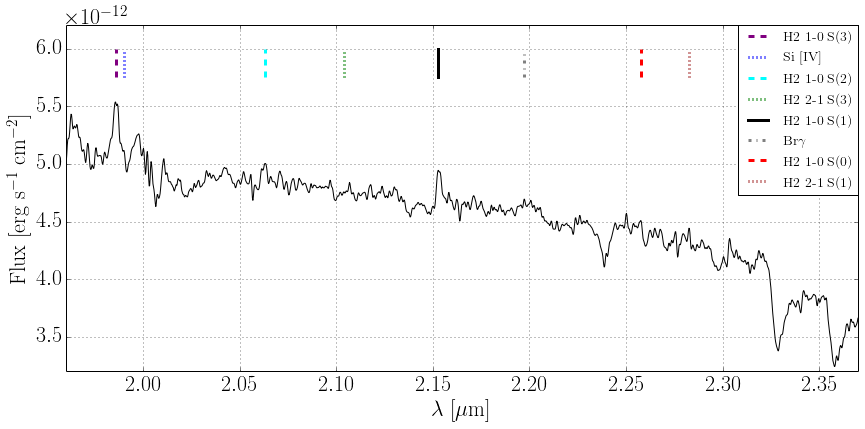

In [8]:
#MAIN to extract the spectrun

#open file
f=pyfits.open(in_file)
infiled=f[0].data
head=f[0].header


#hanning
infiled=hanning_mine(infiled,delta_vel)

spec_cool=np.zeros([infiled.shape[0]])

for i in xrange (0,infiled.shape[0]):
    spec_cool[i]=np.mean(infiled[i,y_d_s:y_u_s,x_l_s:x_r_s])

    
#convert from W/m^2 to erg s^-1 cm^-2: x1e7x1e-4
spec_cool=np.multiply(spec_cool,wave)
spec_cool=spec_cool*1e7

#PLOT

#uptload important parameters
fig = plt.figure(figsize=(14.2,6.2))

params = {'legend.fontsize': 14,
          'axes.linewidth':1,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})


plt.rcParams.update(params)
a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]',fontsize=22)
plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)
a.set_xlim([1.960,2.37])
a.set_ylim([3.2*1e-12,6.2*1e-12])

#plot the spectrum
a.plot(wave[z_low:z_up],spec_cool[z_low:z_up],c='black',lw=1)

# draw detectable lines approximately where they should be
#S(3)
#S(3) line
z_3_low=220
z_3_up=248
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
a.plot(s3_x,s3_y,lw=3,color='purple',label=r'H2 1-0 S(3)',ls='--')

#detected lines
#Si IV
siv_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_3_up:z_3_up+10])
siv_x=[wave[z_3_up+peak],wave[z_3_up+peak]]
a.plot(siv_x,siv_y,lw=3,color='blue',label=r'Si ${\rm[\small IV]}$',ls=':')

#S(2)
s0_l=520
s0_r=580
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='cyan',label=r'H2 1-0 S(2)',ls='--')

#2-1S(3)
s0_l=700
s0_r=720
s3_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s3_x,s3_y,lw=3,color='green',label=r'H2 2-1 S(3)',ls=':')

#S(1)
#S(1) line
z_l_low=899
z_l_up=932
s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
a.plot(s1_x,s1_y,lw=3,color='black',label=r'H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='grey',label=r'Br$\gamma$',ls='-.')


#S(0)
s0_l=1340
s0_r=1370

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='red',label=r'H2 1-0 S(0)',ls='--')

#2-1S(1)
s0_l=1420
s0_r=1448

s1_y=[5.75*1e-12,6.0*1e-12]
peak=np.argmax(spec_cool[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
a.plot(s1_x,s1_y,lw=3,color='brown',label=r'H2 2-1 S(1)',ls=':')

#plot fancy things
plt.legend(loc=(0.849,0.51))
plt.grid()

fig.savefig(outfile_fig)



# Stellar continuum subtraction

Define the main parameters:

- Output file names

  - Cubes
     - stellar continuum : out_stars
     - continuum subtracted: out_starsub
     - smoothed median subtrated : out_nh
     - hanned median subtracted : out_h
     - mask for the line emission regions : mask_file
     

In [9]:
out_starsub=root_cube+'starsub.fits'
out_stars=root_cube+'stars.fits'

out_nh=root_cube+'nh.fits'
out_h=root_cube+'h.fits'

mask_file=root_mask+'H2_mask.fits'


- Constants
    
    - Edges of the cube
    - Cutoff values
    - Hanning number of channels
    - Convolution beam in arcsecons : cube and masks


In [10]:
#Spectral limits
z_low=100
z_up=2000

# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#cutoff value for the mask 
value=3

#hanning width
delta_vel=7 # number of channels

#spatial convolution gaussian
sigma=300./3600.  #in degrees #parameter for the emission cubes
sigma_masch=200./3600.  #in degrees   #parameter for the mask


- Functions

  - stellar subtraction

  - median subtraction

  - hanning

  - convolution
  
  - median edges definition
  
  - making masks

In [11]:
def stellar_template(masDat,copDat,data):

    avSpec_left = np.zeros(zlen)
    spec_cont=np.zeros([zlen,ylen,xlen]) 
    numSpecs_left = 0.0

    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            if (masDat[j,i] <= 0.01) :
                spec = data[:,j,i]
                s = spec[z_low:z_up].sum()
                avSpec_left[z_low:z_up] = avSpec_left[z_low:z_up]+spec[z_low:z_up]*s*s
                numSpecs_left += s*s
    
    avSpec_left = avSpec_left/numSpecs_left
    
    for i in range(x_low,x_up) :
        for j in range(y_low,y_up) :
            spec = data[:,j,i]
            s = spec[z_low:z_up].sum()
            ss = avSpec_left[z_low:z_up].sum()
            copDat[z_low:z_up,j,i] = data[z_low:z_up,j,i] - avSpec_left[z_low:z_up]*s/ss
            spec_cont[z_low:z_up,j,i]=avSpec_left[z_low:z_up]*s/ss

            
    #writing outputs        

    pyfits.writeto(out_starsub, copDat[:,:,:], head.copy(), clobber = True)    
    pyfits.writeto(out_starsub, spec_cont[:,:,:], head.copy(), clobber = True)            
            
    return copDat,avSpec_left


def subfirst(copDat,masDat,data):


    stellar_template(masDat,copDat,data)


    #median method : S(3) line

    z_giu_l3=z_low
    z_su_r3=600

    a_l=120
    a_r=210
    b_l=250
    b_r=400
    
    copDat=median_mine(copDat,z_giu_l3,z_su_r3,a_l,a_r,b_l,b_r)

    #median method : S(1) line
    
    z_giu_l1=z_su_r3
    z_su_r1=1040

    a_l=z_su_r3
    a_r=895
    b_l=932
    b_r=z_su_r1
    copDat=median_mine(copDat,z_giu_l1,z_su_r1,a_l,a_r,b_l,b_r)

    
    #median method : other  line 

    z_giu_br=z_su_r1
    z_su_br=1260

    a_l=z_su_r1
    a_r=1084
    b_l=1100
    b_r=z_su_br 
     
    copDat=median_mine(copDat,z_giu_br,z_su_br,a_l,a_r,b_l,b_r)
    
    
    #median method around the other lines

    z_giu_o=z_su_br
    z_su_o=z_up

    a_l=z_su_br
    a_r=1300
    b_l=1536
    b_r=1860 
     
    copDat=median_mine(copDat,z_giu_o,z_su_o,a_l,a_r,b_l,b_r)
    
    #convolution

    copDat=convolution(copDat,sigma,z_low,z_up) 
    pyfits.writeto(out_nh, copDat[:,:,:], head.copy(), clobber = True)

    #hanning
  
    copDat=hanning_mine(copDat,delta_vel)   
    pyfits.writeto(out_h, copDat[:,:,:], head.copy(), clobber = True)


    return copDat

def maskk(infiled,value):
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l_low=899
    z_l_up=932
    
    #edges for the noise estimation needed to set the cutoff
    x_nl=16
    x_nr=36
    y_nd=50
    y_nu=60
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l_low,z_l_up):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
        mask2d+=mask[k,:,:]
     
    mask_smooth2d=np.zeros([infiled.shape[1],infiled.shape[2]])
    mask_smooth2d=convolution2d(mask2d,sigma_masch)
    
    
    return mask_smooth2d

MAIN of the stellar continuum pipeline

In [14]:
##### MAIN MAIN MAIN

print '*********************'
print 'Start preparing cubes'

f=pyfits.open(input_file)
head=f[0].header
data=f[0].data

mas = pyfits.open(mask_file)
masDat = mas[0].data

xlen = data.shape[2]
ylen = data.shape[1]
zlen = data.shape[0]

#set some arrays
spec_medio= np.zeros(zlen)
copDat = np.zeros([zlen,ylen,xlen])
copCont = np.zeros([zlen,ylen,xlen])

#set the spectral band
#wave = (np.linspace(1,data.shape[0],data.shape[0])-head['CRPIX3'])* head['CDELT3'] + head['CRVAL3']
# in frequency
#wave_freq=np.array([])
#wave_freq=C/(wave*1e-6)

#iterative masking and continuum subtracting
copDat=subfirst(copDat,masDat,data)



masDat_new2d=maskk(copDat,value)

copDat = np.zeros([zlen,ylen,xlen])
copDat=subfirst(copDat,masDat_new2d,data)

print 'END of preparing cubes'
print '*********************\n'


*********************
Start preparing cubes
END of preparing cubes
*********************



# Moment maps production

Produce Intensity and Velocity field of the H2 1-0 S(1) line


** Moment 0 maps are produced in RELATIVE FLUX [ x 10^12 erg s^-1 cm^-2] **

** Moment 1 maps are in km s^-1 relative to the systemic velocity = vel_sys in fundamental parameters **

SINFONI input maps: W m^-2

Conversion to erg s^-1 cm^-2: x 10^7 x 10^-4


*****************


Define the main parameters:

-Input files
    
    - final data cube = out_nh in "Stellar continuum subtraction" 
    
    - cube of the stellar continuum = out_stars in "Stellar continuum subtraction"
    
    - hanned final data cube = out_h - to create the masks for the moment 0 and 1 maps
    



In [15]:
in_nh=root_cube+'nh.fits'       #final data cube
in_stars=root_cube+'stars.fits' #same as out_stars in stellar continuum
in_h=root_cube+'h.fits'         #hanned final data cube

 - Output file names
   - name of the line
   - Cubes
   - Images
   - Figures

In [16]:
linename='s1'

#cubes
out_int_cu=root_cube+'int_cube_'+linename+'.fits'

#images
out_int_im=root_images+'int_im_'+linename+'.fits'
out_vel_im=root_images+'vel_im_'+linename+'.fits'

#figures
out_int_fig=root_figures+'int_'+linename+'.pdf'
out_vel_fig=root_figures+'vel_'+linename+'.pdf'

#masks
out_vel_mask=root_mask+'vel_mask_'+linename+'.fits'


- Constants
    - location of the line in channels (edges of the integration) and edges of the field of view
    - edges of the field of view, to estimate the noise, and to build the moment maps
    - parameters to smooth the cube and the masks for moment 0 and 1 maps and the mask
    - signal cutoff to produce the maps (in rms noise)
    - sigma contour leves for plotting
    - direction of the continuum of the radio jets 
        - array extension in x,y pixel coordinates
        - position angle

In [17]:
#S(1) line
z_l_low=901
z_l_up=930
# EDGES of the Field of VIEW 
x_low=12
y_low=12

x_up=64
y_up=64

#edges for the noise estimation within the field of view in channels
x_nl=16
x_nr=36
y_nd=50
y_nu=60

z_l=899
z_u=932

#spatial convolution gaussian
sigma_vel=350./3600.  #in degrees
sigma_int=320./3600.  #in degrees
sigma_masch=390./3600.  #in degrees

#rms noise cutoff 
value_vel=2.5
val_int=2.2

#sigma values on the noise for the contours
val_sig_int=[1.6,3,5,7,9,12]

#direction of the continuum of the radio jets
x_mid=41
y_mid=39
x_loww=36.5
x_upp=45.5
pa_cont_ALL=42 

In [21]:
def intensity(infiled,mask,wave):

    print 'INTENSITY'

    intens=np.zeros([infiled.shape[1],infiled.shape[2]])
    intensnew=np.zeros([infiled.shape[1],infiled.shape[2]])
   

    diff=0.0 
    noise_int=0.0
    n=0.0
    for k in xrange(z_l,z_u):
        noise_int+=(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))*(np.std(infiled[k,y_nd:y_nu,x_nl:x_nr]))
        diff+=wave[k+1]-wave[k]
        n+=1.
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):             
                if mask[k,j,i]>=0.001:
                    intens[j,i]=intens[j,i]+infiled[k,j,i]

    
    ##set the right units:
    # from W/m^2 * 1e7*1e-4 = erg/s cm^-2  * 1e8 to normalize
    
    diff_av=abs(diff/n)
    intens=np.multiply(intens,diff_av)
 
    noise_int=np.sqrt(noise_int)*diff_av
    val_int=np.multiply(val_sig_int,noise_int)

    for k in xrange(z_l_low,z_l_up): 
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  intens[j,i]>=val_int[0]:
                    intensnew[j,i]=intens[j,i]
 

    intens=intensnew*1e7/1e-16
    val_int=val_int*1e7/1e-16
    

    #write output image .figs
    pyfits.writeto(out_int_im,intens, head.copy(), clobber = True) 
    #write output cube .figs
    pyfits.writeto(out_int_cu,infiled[z_l:z_u,:,:], head.copy(), clobber = True) 
 


    #determine the direction of the radio jets of the continuum
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    
    ##MAKE PLOT .pdf
    #PLOT

    #open HANNED cube for aplpy
    #f=pyfits.open(in_h)
    #headd=f[0].header

    #set initial parameters of the plot
    f = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)

    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    #f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),
               height=math.radians(6.2/60.))
    
    f.axis_labels.set_font(size=20,weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20,weight=300, \
                         style='normal',stretch='ultra-condensed')


    #plot the direction of the radio jets
    plt.plot(x3,y3,color='green',lw=4,ls='--')
    
    #plot the moment zero map
    im = plt.imshow(intens[x_low:x_up,y_low:y_up], cmap='gist_heat_r',origin='lower',interpolation='spline36',
                    vmin=np.min(intens[x_low:x_up,y_low:y_up]),
                    vmax=np.max(intens[x_low:x_up,y_low:y_up]),
                    extent=(x_low,x_up,y_low,y_up))
    #and its contours                   
    cset = contour(intens[x_low:x_up,y_low:y_up],val_int,origin='lower',colors='gray',linewidths=1,ls=':',
                   extent=(x_low,x_up,y_low,y_up))
    
    #plot contours of isophotes
    
    #open stars cube to plot the isophotes
    #f=pyfits.open(in_stars)
    
    #determine noise of the cube for contour levels
    #stars=f[0].data 
    #stars_image=np.zeros([ylen,xlen])
    #mean_value=0.0
    
    #for i in xrange(700,750):
    #    stars_image+=stars[i,:,:]
    #    mean_value+=np.std(stars[i,51:61,15:34])
        
    #set contour levels
    #value=[mean_value,5.*mean_value,7.*mean_value,9.*mean_value,15.*mean_value]
    #plot contours
    #cset = contour(stars_image[x_low:x_up,y_low:y_up],value,origin='lower',colors='black',linewidths=1,ls=':',
    #               extent=(x_low,x_up,y_low,y_up))

    
    cbar=plt.colorbar(im,spacing='uniform')
    cbar.ax.tick_params(direction='out')
    cbar.ax.get_yaxis().labelpad = 2
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel(r'Relative Intensity', rotation=90,fontsize=20)
    
  
    #save the image
    f=plt.savefig(out_int_fig,clobber='yes')
    
    
    return val_int

def velocity(infiled,mask,vel,val):
    
    print 'VELOCITY'

    #define vectors for integral
    velox=np.zeros([infiled.shape[1],infiled.shape[2]])
    velox_sum=np.zeros([infiled.shape[1],infiled.shape[2]])
    veloc=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])

    #determine the moment 1 map
    print val
    diff=0.0
    for k in xrange(z_l,z_u):
        diff=vel[k+1]-vel[k]
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=val_vel[0]*noise     
        for j in xrange(y_low,y_up):
            for i in xrange(x_low,x_up):     
                if  mask[j,i]>=val[0] and infiled[k,j,i]>=values:
                    velox[j,i]=velox[j,i]+infiled[k,j,i]*vel[k]*diff
                    velox_sum[j,i]=velox_sum[j,i]+infiled[k,j,i]*diff
                    veloc[k,j,i]=infiled[k,j,i]*vel[k]*diff
                    

    # setright units
    velox_tot=np.divide(velox,velox_sum)

    #relative to the systemic velocity
    velox_tot=velox_tot-vel_sys

    #determine the direction of the radio jets
    x3=np.linspace(x_loww,x_upp,100)
    m=np.tan(math.radians(pa_cont_ALL))
    y3=m*(x3-x_mid)+y_mid
    
    ## Make Plot .pdf
    #PLOT

    #set the right parameters for the plot
    ff = plt.figure(figsize=(8,8))
    params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':20,
           'ytick.labelsize':20,
           'xlabel.fontsize':20,
           'ylabel.fontsize':20,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})

    plt.rcParams.update(params)


    f = aplpy.FITSFigure(in_nh,dimensions=[0,1],slices=[0],tight_layout=True)
    #f.add_grid()
    f.recenter(float(headd['CRVAL1'])+0.00027,float(headd['CRVAL2'])-0.00007,width=math.radians(6.1/60.),height=math.radians(6.2/60.))

    f.axis_labels.set_font(size=20, weight=300, \
                         stretch='ultra-condensed',\
                         style='normal', variant='normal')
    
    f.ticks.set_xspacing(0.0015)  # degrees
    f.tick_labels.set_font(size=20, weight=300, \
                         style='normal',stretch='ultra-condensed')
    
    #plot the direction of the radio jet
    plt.plot(x3,y3,color='black',lw=4,ls='--')
    
    #plot the moment 1 map
    im = plt.imshow(velox_tot[x_low:x_up,y_low:y_up], cmap='nipy_spectral',interpolation='spline36',origin='lower'
                    ,vmin=-300,vmax=300,extent=(x_low,x_up,y_low,y_up))

    
    # plot the colors
    cbar=plt.colorbar(im) 
    cbar.ax.get_yaxis().labelpad = - 10
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.set_ylabel(r'km s$^{-1}$', rotation=90,fontsize=20)
    
    #draw intensity contours
    cset = contour(mask[x_low:x_up,y_low:y_up],val,origin='lower',colors='black',linewidths=1,ls=':',extent=(x_low,x_up,y_low,y_up))
    
    #save the figure
    ff=plt.savefig(out_vel_fig)
    
    #write output image
    pyfits.writeto(out_vel_im,velox_tot, head.copy(), clobber = True)     
    
    #write output mask 
    pyfits.writeto(out_vel_mask,mask, head.copy(), clobber = True)  

    return velox_tot

def mask_int(infiled,value):

    def convolution(inputt,sigma):
     
        mu=0.0
        x=np.linspace(-1,1,21)
        arg=-((x-mu)*(x-mu))/(2*sigma*sigma)
        gauss_ra=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)       

 
        
        kernel = gauss_ra.reshape(21, 1) * gauss_ra.reshape(1, 21)               
        kernel /= kernel.sum()

        inputta=np.zeros([inputt.shape[0],inputt.shape[1],inputt.shape[2]])
        
        for k in xrange(z_l_low,z_l_up):
            inputta[k,:,:] = scipy.signal.convolve2d(inputt[k,:,:], kernel, mode='same')
        
        return inputta
    
    #S(1) line # because I mask where there is NO H2 1-0 S(1) line emission
    z_l=899
    z_up=932
    
    #edges for the noise estimation needed to set the cutoff
    
    #make the mask
    mask=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    n=0
    for k in xrange (z_l,z_u):
        noise=np.std(infiled[k,y_nd:y_nu,x_nl:x_nr])
        values=value*noise/1.
        n+=1
        for j in xrange (y_low,y_up):
            for i in xrange (x_low,x_up):
                if infiled[k,j,i]>values:
                    mask[k,j,i]=1.
                else:
                    mask[k,j,i]=0.0
     
    mask_smooth=np.zeros([infiled.shape[0],infiled.shape[1],infiled.shape[2]])
    mask_smooth=convolution(mask,sigma_masch)
    
    
    return mask_smooth


MAIN of the moment maps production

Populating the interactive namespace from numpy and matplotlib
INTENSITY

`%matplotlib` prevents importing * from pylab and numpy
/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Users/maccagni/Documents/PhD/PKS/H2/data/images/int_im_s1.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)



VELOCITY

/Library/Python/2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Users/maccagni/Documents/PhD/PKS/H2/data/cubes/int_cube_s1.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Library/Python/2.7/site-packages/ipykernel/__main__.py:160: RuntimeWarning: invalid value encountered in divide



[ 0.51274594  0.96139864  1.60233107  2.24326349  2.88419592  3.84559456]
NORMAL TERMINATION


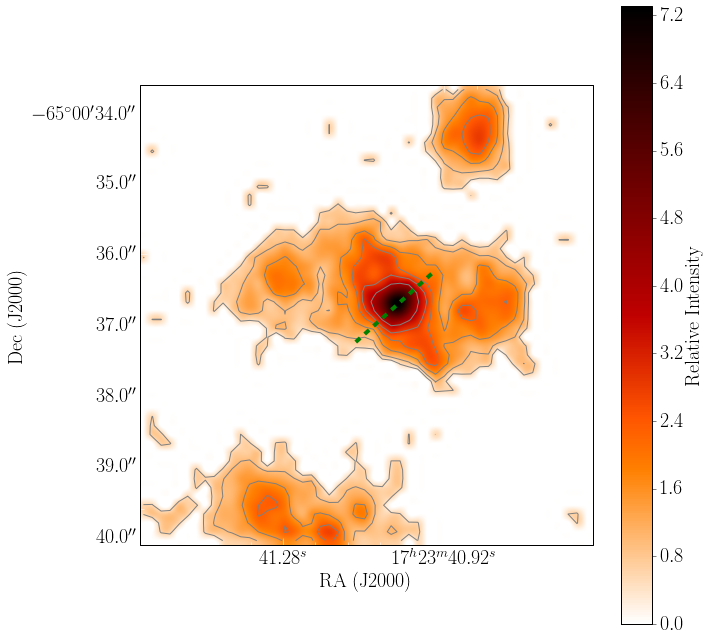

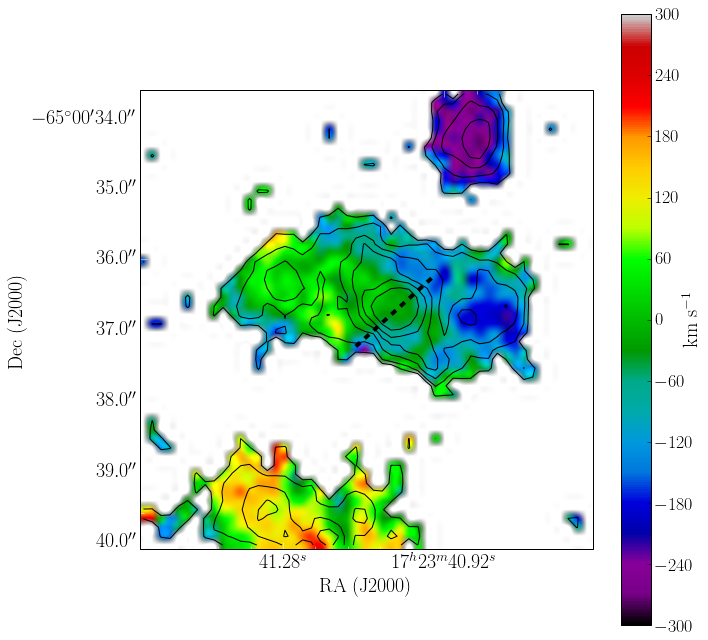

In [22]:
## MAIN for moment map production
get_ipython().magic(u'pylab inline')

#intensity
#make a mask using the hanned cube
f=pyfits.open(in_nh)
in_m=f[0].data
headd=f[0].header
mask=mask_int(in_m,value_vel)
#open final cube cube
f=pyfits.open(in_nh)
infile=f[0].data
head=f[0].header
val_vel=intensity(infile,mask,wave)


#velocity
#open the intensity map to use as a mask
f=pyfits.open(out_int_im)
infiled=f[0].data

#determine the velocity of the line in km/s
vel_s1=(C*(wave*1e-6-s1_0)/s1_0)*1e-3 #!!!!!!!!!
#vel_s1=vel_vec(wave,s1_0)

cassa=velocity(infile,infiled,vel_s1,val_vel)

print 'NORMAL TERMINATION'

*****************************************
# Analysis of the centre

    - spectrum in 3 adjacent regions
    - position velocity diagram along the major axis of the inner disk
    
** Spectrum **

Define input and output files:

    - Input: final cube
    - Filename output figure

In [39]:
in_file=rootdir+'combinOB13.fits'
out_fig_spec=root_figures+'spectrum_centre_regions.pdf'

Define the regions where to extract the spectrum:

    - location of the line in channels
    - regions in pixels
        - centre
        - left
        - right
    
- hanning of the cube in channels

In [40]:
#S(1) line
z_l_low=899
z_l_up=932

#centre
x_mid=41
y_mid=39
#left
x_LL=37
x_LR=39
#right
x_RR=42
x_RL=44
#hanning
delta_vel=7

MAIN to extract and plot the spectrum

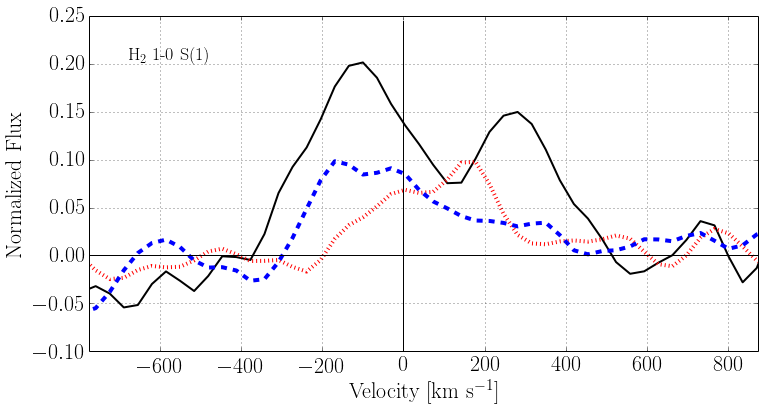

In [20]:
#SPECTRUM

#load input file
f=pyfits.open(in_file)
head=f[0].header
datat=f[0].data

#hanning 
datat=hanning_mine(datat,delta_vel)

vel_s1=vel_vec(wave,s1_0)

z_l_low=z_l_low-100
z_l_up=z_l_up+100

specsum_l = np.zeros([datat.shape[0]])
specsum_r = np.zeros([datat.shape[0]])
n=0.
for i in xrange(37,39):
    specsum_l[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.
    
specsum_l/=n

n=0.
for i in xrange(42,44):
    specsum_r[z_l_low:z_l_up]+=datat[z_l_low:z_l_up,39,i]
    n+=1.    
specsum_r/=n

#straighten the spectrum
datat[z_l_low:z_l_up,y_mid,x_mid]=datat[z_l_low:z_l_up,y_mid,x_mid]-np.median(datat[z_l_low:z_l_up,y_mid,x_mid])
specsum_l[z_l_low:z_l_up]=specsum_l[z_l_low:z_l_up]-np.median(specsum_l[z_l_low:z_l_up])
specsum_r[z_l_low:z_l_up]=specsum_r[z_l_low:z_l_up]-np.median(specsum_r[z_l_low:z_l_up])


#convert everything to the normalized units

#regions left and right
specsum_l=np.divide(specsum_l,wave_freq)
specsum_l=specsum_l*1e7*1e23*1e3
specsum_r=np.divide(specsum_r,wave_freq)
specsum_r=specsum_r*1e7*1e23*1e3

#centre
vec=np.array(datat[:,y_mid,x_mid])
datal=np.divide(vec,wave_freq)
datal=datal*1e7*1e23*1e3

#shift to the systemic velocity
diff=0.0
n=0.0
for i in xrange (z_l_low+100,z_l_up-100):
    diff+=vel_s1[i+1]-vel_s1[i]
    n+=1.



fig = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})

plt.rcParams.update(params)

a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
#a.set_xticks(diffvec,minor=True)
#a.xaxis.grid(True, which='minor')
a.plot(vel_s1[z_l_low:z_l_up],datal[z_l_low:z_l_up],c='black',lw=2,label='centre')
a.plot(vel_s1[z_l_low:z_l_up],specsum_l[z_l_low:z_l_up],c='red',lw=4,label='left',ls=':')
a.plot(vel_s1[z_l_low:z_l_up],specsum_r[z_l_low:z_l_up],c='blue',lw=4,label='right',ls='--')
a.set_xlim([-774,874])
a.set_ylim([-0.1,0.25])
plt.ylabel('Normalized Flux',fontsize=22)
plt.xlabel(r'Velocity [km s$^{-1}$]',fontsize=22)

#o line
c=[-774,874]
d=[0,0]
a.plot(c,d,lw=1,c='black')


#o line
c=[-0.1,0.245]
d=[0,0]
a.plot(d,c,lw=1,c='black')


#plot fancy stuff
a.annotate(r'H$_2$ 1-0 S(1)', xy=(0.12, 0.85), xycoords='axes fraction', fontsize=18,
                horizontalalignment='center', verticalalignment='bottom')

#plt.legend()
plt.grid()
plt.show()

fig.savefig(root_figures+'spectrum_cont.pdf',bbox_inches='tight')

** Position Velocity Diagram **

Define input and output files:

    - Input: final hanned cube
    - Output: Filename output figure
              Filename output fitsfile (which can be an input only for plotting)

In [42]:
in_file=root_cube+'h.fits'
out_pv=root_images+'pv_plot.fits'
#out_pv=root_images+'pv_plot_s1_40.fits'
out_pv_fig=root_figures+'pv_plot.pdf'

Define important parameters:
    
    - location of the line in channels
    - region of the field of view where to make the cut
    - size of pixel in parsec for header of fitsfile

In [43]:
#S(1) line
z_l_low=899
z_l_up=932

#region
x_l_s=39-20
x_r_s=42+20
y_mid=40

#pixel size
#1 pixel = 0.125 arcseconds= 36.8194 pc
c_delt1 =36.8194

In [44]:
#MAIN PV-PLOT
#H2
file=root_cube+'h.fits'
f=pyfits.open(in_file)
infiled=f[0].data
headd=f[0].header

wave = (np.linspace(1,infiled.shape[0],infiled.shape[0])-headd['CRPIX3'])* headd['CDELT3'] + headd['CRVAL3']

#Extract pv-plot image and save it
x_l_s=39-20
x_r_s=42+20
y_mid=40

xdim= x_r_s-x_l_s

vel=(C*(wave*1e-6-s1_0)/s1_0)*1e-3
vel=vel-(vel_sys-68.)
#vel=vel_vec(wave,s1_0)
xmid=(x_r_s-x_l_s)/2.
zdim=z_l_up-z_l_low

#1 pixel = 0.125 arcseconds= 36.8194 pc

#xdim_pc=xdim*36.8194

diff=0.
n=0.
i=0.0
for i in xrange(z_l_low,z_l_up):
    diff+=vel[i+1]-vel[i]
    n+=1.

diff=diff/n

#pv plot header
pv = pyfits.PrimaryHDU()
head_pv=pv.header
head_pv.set('NAXIS',2,after='BITPIX')
head_pv.set('NAXIS1',xdim,after='NAXIS')
head_pv.set('NAXIS2',zdim,after='NAXIS1')
head_pv.set('CTYPE1','Offset [pc]',after='NAXIS2')
head_pv.set('CRPIX1',xmid+0.5,after='CTYPE1')
head_pv.set('CRVAL1',0.0,after='CRPIX1')
head_pv.set('CDELT1',36.8194,after='CRVAL1')
head_pv.set('CTYPE2','VEL-OPT',after='CDELT1')
head_pv.set('CRPIX2',1,after='CTYPE2')
head_pv.set('CRVAL2',vel[z_l_low],after='CRPIX2')
head_pv.set('CDELT2',diff,after='CRVAL2')

#s(1)
pv_plot=infiled[z_l_low:z_l_up-1,y_mid,x_l_s:x_r_s-1]
pv_plot=convolution2d(pv_plot,300./3600.)

#output file
pyfits.writeto(out_pv,pv_plot, head_pv.copy(), clobber = True)     

print 'NORMAL TERMINATION'


NORMAL TERMINATION


Plot the Position Velocity diagram

    - define edges for the noise estimation
    - define contour values in units of sigma
    - define Hernquist profile for rotation curve of stellar component
    - define Keplerian profile for rotation of BH (M ~ 4 10^8 M_Sun)

In [45]:
#estimate the noise for the contours
x_l_sn=25
x_r_sn=42
z_l_downn=20
z_l_upn=32

#countours
val_sig_neg=[-1.5,-2.5]
val_sig=[2,3,5,7,9,12]


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


[   0.            4.82816207    6.82755745 ...,  188.49203326  188.52728415
  188.56251878]
[ 239.473317    237.98976092  236.53343981 ...,   46.98718813   46.97588068
   46.9645814 ]
[ 239.473317    242.81792299  243.36099726 ...,  235.47922139  235.50316484
  235.52710018]


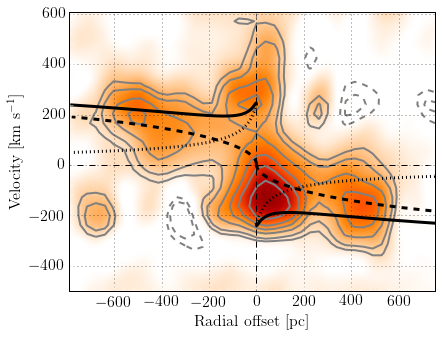

In [46]:
#PLOT

#define the function of the Hernquist profile
def  HernVel(radius, mass, effRadius) :
    
    MASS_CONST  = 2.31 * 10**5
    scaledRadius = effRadius / 1.8153
    retValue=np.zeros([len(radius)])

    for i in xrange (len(radius)):
        retValue[i] = math.sqrt(mass * radius[i]/MASS_CONST)
        retValue[i] = retValue[i] / (radius[i] + scaledRadius)
   
    return retValue

f=pyfits.open(out_pv)
pv_plot=f[0].data
headd=f[0].header


#set the parameters of the plot
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xticks.labelsize':1,
           'xtick.labelsize':16,
           'ytick.labelsize':16,
           'xlabel.fontsize':16,
           'ylabel.fontsize':16,
           'text.usetex': True,
           'text.latex.unicode' : True }

#from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})


plt.rcParams.update(params)


#plot figure

fig = aplpy.FITSFigure(out_pv,figsize=(8,5))
#fig.set_theme('publication')


#draw pvplot
im=plt.imshow(pv_plot, cmap='gist_heat_r',origin='lower',interpolation='spline36',vmin=0.027e-21,vmax=3.20e-20,
              extent=[0,43,-1,35])


#Positive and negative contours



pv_plot_noise=pv_plot[z_l_downn:z_l_upn,x_l_sn:x_r_sn]
noise_pv=np.std(pv_plot_noise)*1.1
val_pv=np.multiply(val_sig,noise_pv)
noise_pv=np.std(pv_plot_noise)/1.3

val_pv_neg=np.multiply(val_sig_neg,noise_pv)

#plot contours
cset = contour(pv_plot,val_pv,linewidths=2,origin='lower',colors='gray',extent=[0,43,-1,33])
cset = contour(pv_plot,val_pv_neg,linewidths=2,origin='lower',colors='gray',ls='--',extent=[0,43,-1,33])


##Hernquist profile

effRadius=pow(10,0.99) #kpc
mass=4e11
M_BH=4e8*1.989e33 #g
radius=np.linspace(0,.780,2000) #from 0 to .700 kpc = the maximum radius of the inner H2 disk 
radius_BH=np.linspace(.03,.780,2000) #from 0 to .700 kpc = the maximum radius of the inner H2 disk 

vel_hern=HernVel(radius,mass,effRadius)
#negative velocities since it is a symmetric profile
vel_hern_neg=np.array(-vel_hern)


#add the black hole keplerian power law : propto 1/2
vel_BH=np.sqrt(G*M_BH/(radius_BH*1e3*PC))*1e-5
vel_BH_neg=np.array(-vel_BH)

vel_tot=vel_BH+vel_hern
vel_tot_neg=vel_BH_neg+vel_hern_neg

print vel_hern
print vel_BH

print vel_tot



vel_BH=vel_BH/float(headd['CDELT2'])+15.
vel_BH_neg=vel_BH_neg/float(headd['CDELT2'])+15.
vel_hern=vel_hern/float(headd['CDELT2'])+15.
vel_hern_neg=vel_hern_neg/float(headd['CDELT2'])+15.
vel_tot=vel_tot/float(headd['CDELT2'])+15.
vel_tot_neg=vel_tot_neg/float(headd['CDELT2'])+15.


#radius in pc for plotting
radius=radius*1e3
radius_neg=np.array(-radius)

radius=radius/36.8194+22.0
radius_neg=radius_neg/36.8194+22.0
#radius in pc for plotting
radius_BH=radius_BH*1e3
radius_neg_BH=np.array(-radius_BH)

radius_BH=radius_BH/36.8194+22.0
radius_neg_BH=radius_neg_BH/36.8194+22.0




a=[22.0,22.0]
b=[0,54]
cc=[14.9,14.9]
plt.plot(a,b,c='black',lw=1,ls='--')
plt.plot(b,cc,c='black',lw=1,ls='--')

# plot hernquist profile
plt.plot(radius,vel_hern_neg,marker=' ',lw=3, label='Hernquist profile',color='black',ls='--')
plt.plot(radius_neg,vel_hern,marker=' ',lw=3, color='black',ls='--')

plt.plot(radius_neg,vel_BH,marker=' ',lw=3, color='black',ls=':')
plt.plot(radius,vel_BH_neg,marker=' ',lw=3, color='black',ls=':')

plt.plot(radius_neg,vel_tot,marker=' ',lw=3, color='black',ls='-')
plt.plot(radius,vel_tot_neg,marker=' ',lw=3, color='black',ls='-')

#labels
plt.ylabel(r'Velocity [km s$^{-1}$]',fontsize=16)
plt.xlabel(r'Radial offset [pc]',fontsize=16)
plt.grid()


#SAVE
plt.savefig(out_pv_fig,bbox_inches='tight')




**********
# Further graphycal checks

** Rotation of the stellar component: extracting spectra in the North, South and Centre of the field of view **

Define the main parameters:

    - Input: final data cube
    - Output: filename of figure
    - Regions
    - Edges for polynomial subtraction (median method)
    - hanning width in channels
    - location of the stellar line

In [47]:
in_file=rootdir+'combinOB13.fits'
out_fig_stars=root_figures+'spectrum_stars.pdf'

#North
x_lN=50
x_rN=53
y_dN=57
y_uN=60   

#South
x_lS=24
x_rS=27
y_dS=15
y_uS=18    

#Centre
x_lC=40
x_rC=42
y_dC=39
y_uC=41

#sky edges for polynomial subtraction
x_low=12
y_low=12

x_up=64
y_up=64

z_low=100
z_up=2000

#hanning
delta_vel=9.

#stellar line location
z_low_star=1600
z_up_star=1900

MAIN of the further graphical checks

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


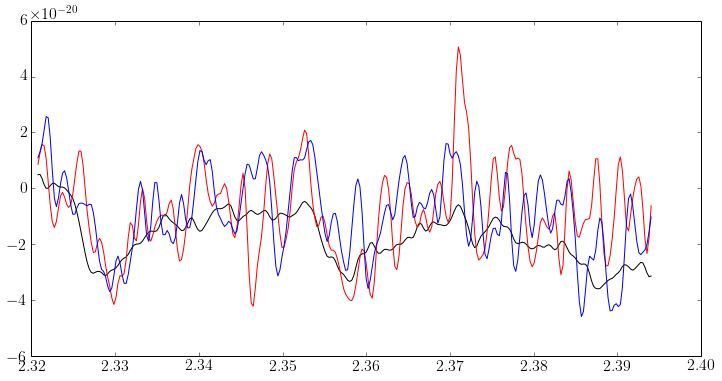

In [48]:
#MAIN

#load the data
f=pyfits.open(in_file)
head=f[0].header
data=f[0].data


copDat = np.zeros([data.shape[0],data.shape[1],data.shape[2]])
copDat[z_low:z_up,y_low:y_up,x_low:x_up]=data[z_low:z_up,y_low:y_up,x_low:x_up]*1.

#hanning
copDat=hanning_mine(copDat,delta_vel)

#median
copDat=median_mine(copDat,z_low,z_up,z_low,z_low+((z_up-z_low)/2.),z_low+((z_up-z_low)/2.),z_up)

#extract the spectra
spec1=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec1[i]=np.mean(copDat[i,y_dC:y_uC,x_lC:x_rC])

    
spec2=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec2[i]=np.sum(copDat[i,y_dS:y_uS,x_lS:x_rS])  
    
 
    
spec3=np.zeros([data.shape[0]])
for i in xrange (0,data.shape[0]):
    spec3[i]=np.sum(copDat[i,y_dN:y_uN,x_lN:x_rN])      
    
    
#PLOT
fig = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})


a = fig.add_subplot(111, autoscalex_on=True,autoscaley_on=True)
a.plot(wave[z_low_star:z_up_star],spec1[z_low_star:z_up_star],c='black',lw=1,label='centre')
a.plot(wave[z_low_star:z_up_star],spec2[z_low_star:z_up_star],c='red',lw=1,label='centre')
a.plot(wave[z_low_star:z_up_star],spec3[z_low_star:z_up_star],c='blue',lw=1,label='centre')

a.set_xlim=([2.3,2.4])

fig.savefig(out_fig_stars,bbox_inches='tight')


** Extract Spectra from 5 regions **

- Define main parameters:
    - Input files
        - Final cube
        - Hanned cube
    - Output figure filenames
    - Output .fits spectra filenames
    - Edges of the regions (x,y)
    - Edges of the S(1) line in channels
    - Spectral limits
    - Normalization factor for the fluxes

In [49]:
#Define parameters
in_file_han=root_cube+'h.fits'
in_file=rootdir+'combinOB13.fits'


out_spec_C=root_spectra+'spectrum_C.fits'
out_spec_W=root_spectra+'spectrum_W.fits'
out_spec_E=root_spectra+'spectrum_E.fits'
out_spec_N=root_spectra+'spectrum_N.fits'
out_spec_S=root_spectra+'spectrum_S.fits'





out_fig_han=root_figures+'spectrum_regions_csub.pdf'
out_fig=root_figures+'spectrum_regions.pdf'

#Spectral limits
z_low=100
z_up=2000
# EDGES of the Field of VIEW 
x_low=12
y_low=12



x_up=64
y_up=64

#edges of the line
z_low_s1=899-15
z_up_s1=932+15

z_low_s1_f=15
z_up_s1_f=15+(z_up_s1-z_low_s1)



#North
x_lN=48
x_rN=52
y_dN=56
y_uN=61   

#South
x_lS=30
x_rS=36
y_dS=11
y_uS=16   

#Centre
x_lC=37
x_rC=42
y_dC=37
y_uC=42

#East
x_lE=27
x_rE=32
y_dE=39
y_uE=43

#West
x_lW=47
x_rW=52
y_dW=36
y_uW=41


#normalization
norma=1e-13


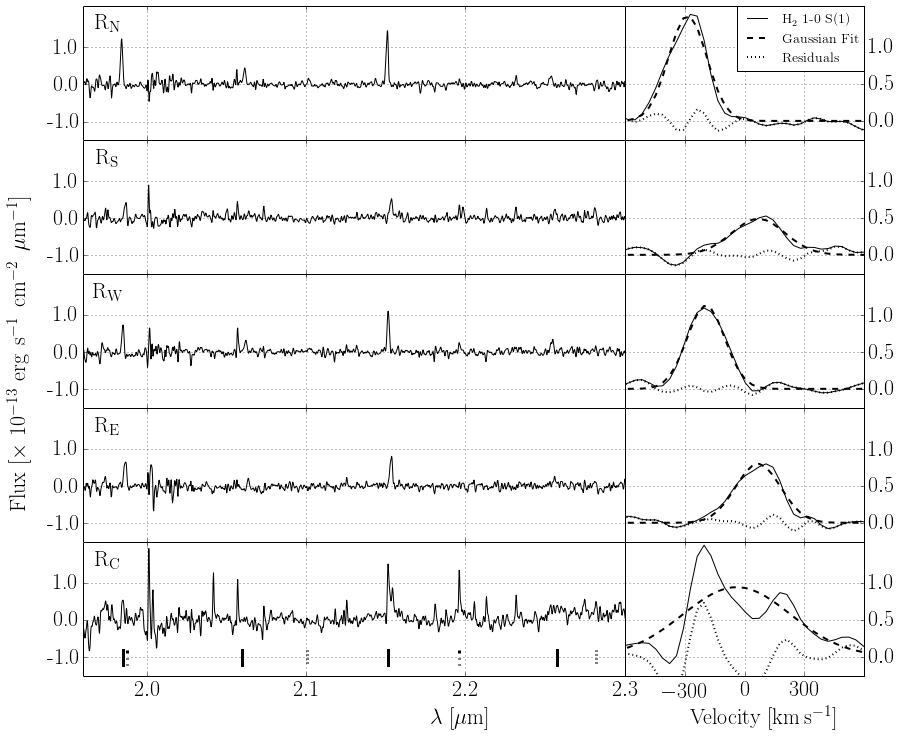

In [50]:
#MAIN MAIN

from scipy.optimize import curve_fit

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))




#load the data
f=pyfits.open(in_file_han)
head=f[0].header
data=f[0].data


copdata = np.zeros([data.shape[0],data.shape[1],data.shape[2]])
#convert in erg/scm^-2 (normalized)
copdata[z_low:z_up,y_low:y_up,x_low:x_up]=data[z_low:z_up,y_low:y_up,x_low:x_up]*1e7/norma
#copdata=hanning_mine(copdata,7)

vel=vel_vec(wave[z_low_s1:z_up_s1],s1_0)
       
#CENTRE
spec_C=np.zeros([copdata.shape[0]])
for i in xrange (z_low,z_up):
    spec_C[i]=np.mean(copdata[i,y_dC:y_uC,x_lC:x_rC])

res_C=np.zeros([vel.shape[0]])
spec_Cv=np.zeros([vel.shape[0]])
spec_Cv[:]=spec_C[z_low_s1:z_up_s1]
 
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., -100., 100.]    
    
#fit:
coeff_C, var_matrix = curve_fit(gauss, vel[z_low_s1_f:z_up_s1_f], spec_Cv[z_low_s1_f:z_up_s1_f], p0=p0)
gauss_fit_C = gauss(vel[:], *coeff_C)

res_C[:]=spec_Cv[:]-gauss_fit_C[:]
               
#NORTH      
spec_N=np.zeros([copdata.shape[0]])
for i in xrange (z_low,z_up):

       spec_N[i]=np.mean(copdata[i,y_dN:y_uN,x_lN:x_rN])        
        
spec_Nv=np.zeros([vel.shape[0]])
spec_Nv[:]=spec_N[z_low_s1:z_up_s1]
res_N=np.zeros([vel.shape[0]])

#FIT
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., -120., 100.]    
coeff_N, var_matrix = curve_fit(gauss, vel[z_low_s1_f:z_up_s1_f], spec_Nv[z_low_s1_f:z_up_s1_f], p0=p0)
gauss_fit_N = gauss(vel[:], *coeff_N)
res_N[:]=spec_Nv[:]-gauss_fit_N[:]
        
#SOUTH       
spec_S=np.zeros([copdata.shape[0]])
for i in xrange (z_low,z_up):

       spec_S[i]=np.mean(copdata[i,y_dC:y_uC,x_lS:x_rS])

res_S=np.zeros([vel.shape[0]])

spec_Sv=np.zeros([vel.shape[0]])
spec_Sv[:]=spec_S[z_low_s1:z_up_s1]
#FIT
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [.5, +100., 100.]
coeff_S, var_matrix = curve_fit(gauss, vel[z_low_s1_f:z_up_s1_f], spec_Sv[z_low_s1_f:z_up_s1_f], p0=p0)
gauss_fit_S = gauss(vel[:], *coeff_S)
res_S[:]=spec_Sv[:]-gauss_fit_S[:]
       
spec_E=np.zeros([copdata.shape[0]])
for i in xrange (z_low,z_up):

       spec_E[i]=np.mean(copdata[i,y_dE:y_uE,x_lE:x_rE])

res_E=np.zeros([vel.shape[0]])
spec_Ev=np.zeros([vel.shape[0]])
spec_Ev[:]=spec_E[z_low_s1:z_up_s1]
#FIT
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [.5, -100., 100.]
coeff_E, var_matrix = curve_fit(gauss, vel[z_low_s1_f:z_up_s1_f], spec_Ev[z_low_s1_f:z_up_s1_f], p0=p0)
gauss_fit_E = gauss(vel[:], *coeff_E)
res_E[:]=spec_Ev[:]-gauss_fit_E[:]

#WEST
spec_W=np.zeros([copdata.shape[0]])
for i in xrange (z_low,z_up):

       spec_W[i]=np.mean(copdata[i,y_dW:y_uW,x_lW:x_rW])

res_W=np.zeros([vel.shape[0]])
spec_Wv=np.zeros([vel.shape[0]])
spec_Wv[:]=spec_W[z_low_s1:z_up_s1]
   
#FIT
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [.1, -100., 100.]
coeff_W, var_matrix = curve_fit(gauss, vel[z_low_s1_f:z_up_s1_f], spec_Wv[z_low_s1_f:z_up_s1_f], p0=p0)
gauss_fit_W = gauss(vel[:], *coeff_W)
res_W[:]=spec_Wv[:]-gauss_fit_W[:]

        


#PLOT:
#PLOT
#fig = plt.figure(figsize=(14,12))
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':5,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)


massimo_y=np.max([np.max(spec_C),np.max(spec_N),np.max(spec_S),np.max(spec_E),np.max(spec_W)])
minimo_y=np.max([np.min(spec_C),np.min(spec_N),np.min(spec_S),np.min(spec_E),np.min(spec_W)])


mino=minimo_y-(minimo_y/100.*.5)
maso=massimo_y+(massimo_y/100.*.5)



fig,ax = plt.subplots(5,1, sharex=True,sharey=True,figsize=(14,12))

plt.ylim((-1.5, 2.1))
plt.xlim((1.96, 2.45))

fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.5, 0.07, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

fig.text(0.8, 0.07,r'Velocity\,\,[km\,s$^{-1}$]',ha='center',fontsize=22)

inset_ax0 = fig.add_axes([0.663, 0.745, 0.237, 0.155])
inset_ax1 = fig.add_axes([0.663, 0.59, 0.237, 0.155])
inset_ax2 = fig.add_axes([0.663, 0.435, 0.237, 0.155])
inset_ax3 = fig.add_axes([0.663, 0.28, 0.237, 0.155])
inset_ax4 = fig.add_axes([0.663, 0.125, 0.237, 0.155])

ax[0].plot(wave[z_low:z_up],spec_N[z_low:z_up],c='black',lw=1)
ax[0].grid()
ax[0].yaxis.set_ticks((-1.0,0.0,1.0))
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

ax[0].xaxis.set_ticks((2.0,2.1,2.2,2.3))

inset_ax0.plot(vel[:],spec_N[z_low_s1:z_up_s1],c='black',lw=1,label=r'H$_2$\,\,1-0\,\,S(1)')
inset_ax0.plot(vel[:], gauss_fit_N[:], c='black',ls='--',lw=2,label=r'Gaussian Fit')
inset_ax0.plot(vel[:], res_N[:], c='black',ls=':',lw=2,label=r'Residuals')
inset_ax0.grid()
inset_ax0.legend(loc=(0.47,0.52))
inset_ax0.set_ylim((-0.26,1.55))
inset_ax0.yaxis.set_ticks((0.0,0.5,1.0))
inset_ax0.yaxis.tick_right()

inset_ax0.set_xlim((-600,600))
inset_ax0.xaxis.set_ticks((-300,0,300))
inset_ax0.set_xticklabels([])




ax[1].plot(wave[z_low:z_up],spec_S[z_low:z_up],c='black',lw=1)
ax[1].grid()

inset_ax1.plot(vel[:],spec_S[z_low_s1:z_up_s1],c='black',lw=1)
inset_ax1.plot(vel[:], gauss_fit_S[:], c='black',ls='--',lw=2)
inset_ax1.plot(vel[:], res_S[:], c='black',ls=':',lw=2)


inset_ax1.grid()
inset_ax1.set_xlim((-600,600))
inset_ax1.xaxis.set_ticks((-300,0,300))
inset_ax1.set_xticklabels([])

inset_ax1.set_ylim((-0.26,1.55))
inset_ax1.yaxis.set_ticks((0.0,0.5,1.0))
inset_ax1.yaxis.tick_right()


ax[2].plot(wave[z_low:z_up],spec_W[z_low:z_up],c='black',lw=1)

inset_ax2.plot(vel[:],spec_W[z_low_s1:z_up_s1],c='black',lw=1)
inset_ax2.plot(vel[:], gauss_fit_W[:], c='black',ls='--',lw=2)
inset_ax2.plot(vel[:], res_W[:], c='black',ls=':',lw=2)


inset_ax2.grid()

inset_ax2.set_xlim((-600,600))
inset_ax2.xaxis.set_ticks((-300,0,300))
inset_ax2.set_xticklabels([])

inset_ax2.set_ylim((-0.26,1.56))
inset_ax2.yaxis.set_ticks((0.0,0.5,1.0))
inset_ax2.yaxis.tick_right()


ax[2].grid()

ax[3].plot(wave[z_low:z_up],spec_E[z_low:z_up],c='black',lw=1)

inset_ax3.plot(vel[:],spec_E[z_low_s1:z_up_s1],c='black',lw=1)
inset_ax3.plot(vel[:], gauss_fit_E[:], c='black',ls='--',lw=2)
inset_ax3.plot(vel[:], res_E[:], c='black',ls=':',lw=2)


inset_ax3.grid()
inset_ax3.set_xlim((-600,600))
inset_ax3.xaxis.set_ticks((-300,0,300))
inset_ax3.set_xticklabels([])

inset_ax3.set_ylim((-0.26,1.56))
inset_ax3.yaxis.set_ticks((0.0,0.5,1.0))
inset_ax3.yaxis.tick_right()

ax[3].grid()


ax[4].plot(wave[z_low:z_up-400],spec_C[z_low:z_up-400],c='black',lw=1)

inset_ax4.plot(vel[:],spec_C[z_low_s1:z_up_s1],c='black',lw=1)
inset_ax4.plot(vel[:], gauss_fit_C[:], c='black',ls='--',lw=2)
inset_ax4.plot(vel[:], res_C[:], c='black',ls=':',lw=2)

inset_ax4.grid()
inset_ax4.set_ylim((-0.26,1.55))
inset_ax4.yaxis.set_ticks((0.0,0.5,1.0))
inset_ax4.yaxis.tick_right()



inset_ax4.set_xlim((-600,600))
inset_ax4.xaxis.set_ticks((-300,0,300))


ax[4].grid()


# draw detectable lines approximately where they should be
#S(3)
#S(3) line
z_3_low=220
z_3_up=240
s3_y=[-0.8,-1.2]
peak=np.argmax(spec_C[z_3_low:z_3_up])
s3_x=[wave[z_3_low+peak],wave[z_3_low+peak]]
ax[4].plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(3)',ls='-')

#detected lines
#Si IV
siv_y=[-0.8,-1.2]
peak=np.argmax(spec_C[z_3_up:z_3_up+10])
siv_x=[wave[z_3_up+peak],wave[z_3_up+peak]]
ax[4].plot(siv_x,siv_y,lw=3,color='black',label='Si $[\small IV]$',ls='-.')

#S(2)
s0_l=530
s0_r=540
s3_y=[-0.8,-1.2]
peak=np.argmax(spec_C[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
ax[4].plot(s3_x,s3_y,lw=3,color='black',label='H2 1-0 S(2)',ls='-')

#2-1S(3)
s0_l=700
s0_r=720
s3_y=[-0.8,-1.2]
peak=np.argmax(spec_C[s0_l:s0_r])
s3_x=[wave[s0_l+peak],wave[s0_l+peak]]
ax[4].plot(s3_x,s3_y,lw=3,color='black',label='H2 2-1 S(3)',ls=':')

#S(1)
#S(1) line
z_l_low=899
z_l_up=932
s1_y=[-0.8,-1.2]
peak=np.argmax(spec_C[z_l_low:z_l_up])
s1_x=[wave[z_l_low+peak],wave[z_l_low+peak]]
ax[4].plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(1)',ls='-')

#brgamma
br_l=1078
br_r=1111

s1_y=[-0.8,-1.2]
peak=np.argmax(spec_C[br_l:br_r])
s1_x=[wave[br_l+peak],wave[br_l+peak]]
ax[4].plot(s1_x,s1_y,lw=3,color='black',label='Br$\gamma$',ls='-.')


#S(0)
s0_l=1330
s0_r=1350

s1_y=[-0.8,-1.2]
peak=np.argmax(spec_C[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
ax[4].plot(s1_x,s1_y,lw=3,color='black',label='H2 1-0 S(0)',ls='-')

#2-1S(1)
s0_l=1420
s0_r=1448

s1_y=[-0.8,-1.2]
peak=np.argmax(spec_C[s0_l:s0_r])
s1_x=[wave[s0_l+peak],wave[s0_l+peak]]
ax[4].plot(s1_x,s1_y,lw=3,color='black',label='H2 2-1 S(1)',ls=':')



fig.text(0.15,0.87,r'R$_{\rm N}$',fontsize=22,ha='center')
fig.text(0.15,0.715,r'R$_{\rm S}$',fontsize=22,ha='center')
fig.text(0.15,0.56,r'R$_{\rm W}$',fontsize=22,ha='center')
fig.text(0.15,0.405,r'R$_{\rm E}$',fontsize=22,ha='center')
fig.text(0.15,0.25,r'R$_{\rm C}$',fontsize=22,ha='center')



plt.subplots_adjust(hspace=0);





fig.savefig(out_fig_han,bbox_inches='tight')





** after having extracted the spectra from the five regions: **

determine the line fluxes the error, and the detection limit.

    - line fluxes are in erg s^-1 cm^-2
        - integrated flux = area of the gaussian
    - error = dispersion of the spectrum in regions adjacent to the lines
    - detection limit 
        3sigma of the spectrum in regions where the line is expected * linewidth (100 km/s, 6.5e-4 mu m)
    
    * Detected lines per region:
        * RN: S(1), S(3)   
        * RS: S(1), S(3)
        * RW: S(1), S(3)
        * RE: S(1), S(3)
        * RC: S(1), S(3), Brgamma
        
    * Undetected lines:
        * S(2), S(0) : at the 2sigma level
        * H2 2-1 S(1),S(3)
        * Si [IV]


- Define regions in channels where we expect to find the lines
- Define expected FWHM of undetected lines in mu m
- Define the filenames of the output figures

In [51]:
#define channels where the lines are expected

#S1
#edges of the line
z_low_s1=890
z_up_s1=932

#S3
#edges of the line
z_low_s3=210
z_up_s3=250

#S2
z_low_s2=520
z_up_s2=560

#S(0)
z_low_s0=1310
z_up_s0=1350

#2-1 S(3)
z_low_213=700
z_up_213=740

#2-1 S(1)
z_low_211=1400
z_up_211=1440

#Bracket gamma
z_low_br=1070
z_up_br=1110

#define the output filenames

out_fig_N=root_figures+'lines_N.pdf'
out_fig_S=root_figures+'lines_S.pdf'
out_fig_W=root_figures+'lines_W.pdf'
out_fig_E=root_figures+'lines_E.pdf'
out_fig_C=root_figures+'lines_C.pdf'

ass_fwhm=1.3e-3

********
** North Region **

H2 1-0 S(1)

Flux [10^-13 erg s^-1 cm^-2]:
2.42e-03
Error [10^-13 erg s^-1 cm^-2]:
7.37e-05
Sigma Velocity [mu m]:
6.78e-04
Sigma Velocity [km s^-1]:
9.58e+01

H2 1-0 S(3)

Flux  [10^-13 erg s^-1 cm^-2]:
2.02e-03
Error [10^-13 erg s^-1 cm^-2]:
7.23e-05
Sigma Velocity [mu m]:
6.60e-04
Sigma Velocity [km s^-1]:
1.01e+02

H2 1-0 S(2)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.41e-04
Error [10^-13 erg s^-1 cm^-2]:
1.14e-04

H2 1-0 S(0)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.28e-04
Error [10^-13 erg s^-1 cm^-2]:
1.09e-04

H2 2-1 S(3)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.41e-04
Error [10^-13 erg s^-1 cm^-2]:
1.14e-04

H2 2-1 S(1)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.51e-04
Error [10^-13 erg s^-1 cm^-2]:
8.38e-05

Si [IV]
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.17e-04
Error [10^-13 erg s^-1 cm^-2]:
7.23e-05

Bracket Gamma
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.13e-04
Error [10^-13 erg s^-1 cm^-2]:
7.11e-05



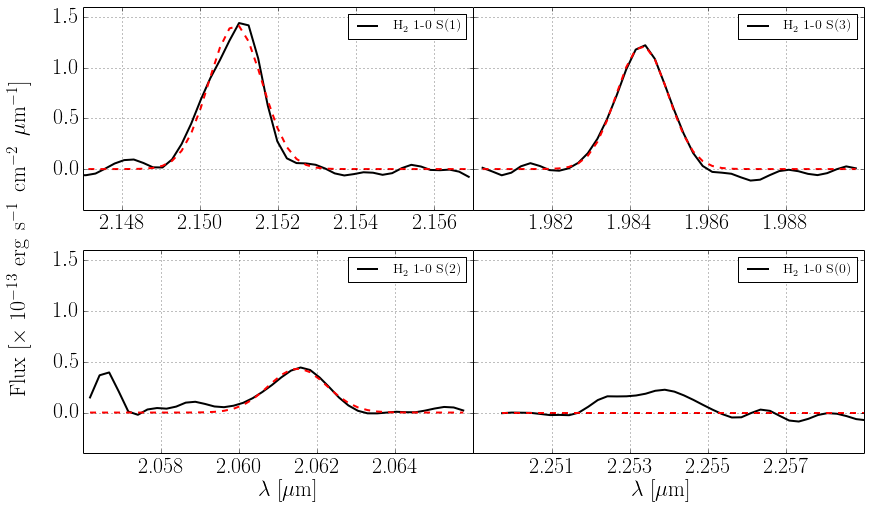

In [52]:
spec_NN=np.copy(spec_N)
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.02]    

#S1 line
#fit in wavelength:
coeff_N, var_matrix = curve_fit(gauss, wave[z_low_s1:z_up_s1], spec_NN[z_low_s1:z_up_s1], p0=p0)
coeff_N=np.abs(coeff_N)

a_N=coeff_N[0]*(np.sqrt(2*np.pi)*coeff_N[2])
gauss_fit_Nw = gauss(wave[z_low_s1:z_up_s1], *coeff_N)

noise_N=np.mean([np.std(spec_NN[z_up_s1+10:z_up_s1+40]),np.std(spec_NN[z_low_s1-40:z_low_s1-10])])
noise_N_area=noise_N*(np.sqrt(2*np.pi)*coeff_N[2])


#S3 line
#fit in wavelength:
p0 = [1.,1.98, 0.02]    

coeff_3N, var_matrix = curve_fit(gauss, wave[z_low_s3:z_up_s3], spec_NN[z_low_s3:z_up_s3], p0=p0)
coeff_3N=np.abs(coeff_3N)

a_3N=coeff_3N[0]*(np.sqrt(2*np.pi)*coeff_3N[2])
gauss_fit_3Nw = gauss(wave[z_low_s3:z_up_s3], *coeff_3N)
noise_3N=np.mean([np.std(spec_NN[z_up_s3+10:z_up_s3+40])])
noise_3N_area=noise_3N*(np.sqrt(2*np.pi)*coeff_3N[2])


#S2 line
#fit in wavelength:
p0 = [1.,2.06, 0.02]    

coeff_2N, var_matrix = curve_fit(gauss, wave[z_low_s2:z_up_s2], spec_NN[z_low_s2:z_up_s2], p0=p0)
coeff_2N=np.abs(coeff_2N)

a_2N=coeff_2N[0]*(np.sqrt(2*np.pi)*coeff_2N[2])
gauss_fit_2Nw = gauss(wave[z_low_s2:z_up_s2], *coeff_2N)

noise_2N=np.mean([np.std(spec_NN[z_up_s2+10:z_up_s2+40]),np.std(spec_NN[z_low_s2-40:z_low_s2-10])])
noise_2N_area=noise_2N*np.sqrt(2*np.pi)*coeff_2N[2]


#S0 line
#fit in wavelength:
p0 = [1.,2.253, 0.04]    

ass_fwhm=coeff_N[2]

                        
coeff_0N, var_matrix = curve_fit(gauss, wave[z_low_s0:z_up_s0], spec_NN[z_low_s0:z_up_s0], p0=p0)
coeff_0N=np.abs(coeff_0N)

a_0N=coeff_3N[0]*(np.sqrt(2*np.pi)*coeff_0N[2])
gauss_fit_0Nw = gauss(wave[z_low_s0:z_up_s0], *coeff_3N)

noise_0N=np.mean([np.std(spec_NN[z_up_s0+10:z_up_s0+40])])
noise_0N_area=noise_0N*ass_fwhm*np.sqrt(2*np.pi)

#2-1 lines:

noise_213N=np.mean([np.std(spec_NN[z_low_213:z_up_213])])
noise_213N_area=noise_213N*ass_fwhm*np.sqrt(2*np.pi)

noise_211N=np.mean([np.std(spec_NN[z_low_211:z_up_211])])
noise_211N_area=noise_211N*ass_fwhm*np.sqrt(2*np.pi)

#bracket gamma
noise_brN=np.mean([np.std(spec_NN[z_up_br+10:z_up_br+30]),noise_N])
noise_brN_area=noise_brN*ass_fwhm*np.sqrt(2*np.pi)

##PLOT
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':2,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)

fig,a = plt.subplots(2,2, sharex=False,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

plt.ylim((-0.4, 1.6))

a[0,0].plot(wave[z_low_s1:z_up_s1], spec_NN[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[0,0].plot(wave[z_low_s1:z_up_s1], gauss_fit_Nw[:],ls='--',c='red')
a[0,0].set_xlim((2.147,2.157))
a[0,0].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

a[0,0].legend()
a[0,0].grid()

a[0,1].plot(wave[z_low_s3:z_up_s3], spec_NN[z_low_s3:z_up_s3],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(3)')
a[0,1].plot(wave[z_low_s3:z_up_s3], gauss_fit_3Nw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[0,1].set_xlim((1.980,1.990))
a[0,1].xaxis.set_ticks((1.982,1.984,1.986,1.988))
a[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[0,1].legend()
a[0,1].grid()

a[1,0].plot(wave[z_low_s2:z_up_s2], spec_NN[z_low_s2:z_up_s2],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(2)')
a[1,0].plot(wave[z_low_s2:z_up_s2], gauss_fit_2Nw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[1,0].set_xlim((2.056,2.066))
a[1,0].xaxis.set_ticks((2.058,2.060,2.062,2.064))
a[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,0].legend()
a[1,0].grid()

a[1,1].plot(wave[z_low_s0:z_up_s0], spec_NN[z_low_s0:z_up_s0],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(0)')
a[1,1].plot(wave[z_low_s0:z_up_s0], gauss_fit_0Nw[:],ls='--',c='red')

a[1,1].set_xlim((2.249,2.259))
a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,1].legend()
a[1,1].grid()

fig.subplots_adjust(wspace=0);

print 'H2 1-0 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_N)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_N_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_N[2])

vel1=(C*(coeff_N[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_N[1]+coeff_N[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)

print 'H2 1-0 S(3)\n'
print 'Flux  [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_3N)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_3N_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_3N[2])

vel1=(C*(coeff_3N[1]*1e-6-s3_0)/s3_0)*1e-3
vel2=(C*((coeff_3N[1]+coeff_3N[2])*1e-6-s3_0)/s3_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


#Determine noise and detection limits for other lines assuming a width of 100 km/s ~6.5e-4 mu m

print 'H2 1-0 S(2)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_2N_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_2N_area)

print 'H2 1-0 S(0)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_0N_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_0N_area)

print 'H2 2-1 S(3)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_213N_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_213N_area)

print 'H2 2-1 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_211N_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_211N_area)

print 'Si [IV]'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_3N_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_3N_area)
print 'Bracket Gamma'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_brN_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_brN_area)

#set fluxes output:

flux_N=[a_3N,noise_2N_area*3.,a_N,noise_0N_area*3.,noise_211N_area*3]
err_flux_N=[noise_3N_area,noise_2N_area,noise_N_area,noise_0N_area,noise_211N_area]


fig.savefig(out_fig_N,bbox_inches='tight')


** South Region **

H2 1-0 S(1)

Flux [10^-13 erg s^-1 cm^-2]:
1.16e-03
Error [10^-13 erg s^-1 cm^-2]:
1.62e-04
Sigma Velocity [mu m]:
9.46e-04
Sigma Velocity [km s^-1]:
1.34e+02

H2 1-0 S(3)

Flux  [10^-13 erg s^-1 cm^-2]:
6.88e-04
Error [10^-13 erg s^-1 cm^-2]:
7.33e-05
Sigma Velocity [mu m]:
6.30e-04
Sigma Velocity [km s^-1]:
9.65e+01

H2 1-0 S(2)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
7.02e-04
Error [10^-13 erg s^-1 cm^-2]:
2.34e-04

H2 1-0 S(0)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.79e-04
Error [10^-13 erg s^-1 cm^-2]:
1.26e-04

H2 2-1 S(3)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.87e-04
Error [10^-13 erg s^-1 cm^-2]:
1.29e-04

H2 2-1 S(1)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
7.25e-04
Error [10^-13 erg s^-1 cm^-2]:
2.42e-04

Si [IV]
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.20e-04
Error [10^-13 erg s^-1 cm^-2]:
7.33e-05

Bracket Gamma
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
3.85e-04
Error [10^-13 erg s^-1 cm^-2]:
1.28e-04



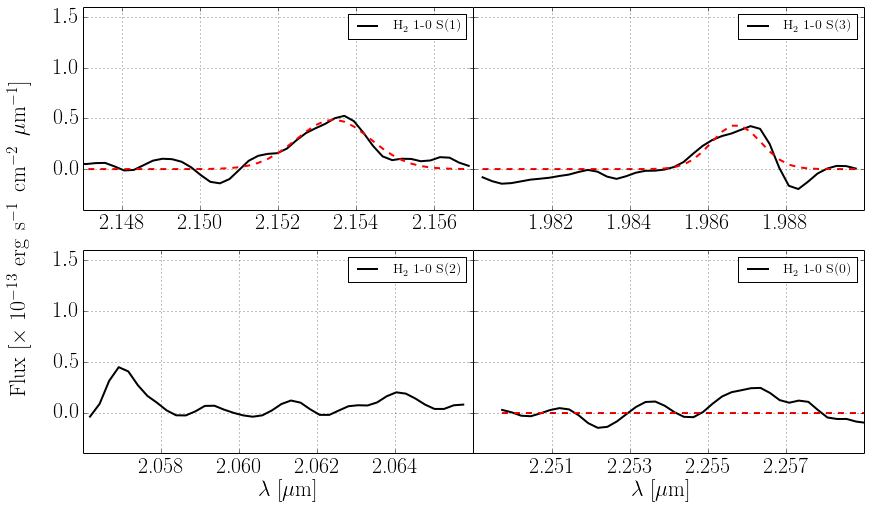

In [53]:
spec_SS=np.copy(spec_S)

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.02]    

#S1 line
#fit in wavelength:
coeff_S, var_matrix = curve_fit(gauss, wave[z_low_s1:z_up_s1], spec_SS[z_low_s1:z_up_s1], p0=p0)
coeff_S=np.abs(coeff_S)

a_S=coeff_S[0]*(np.sqrt(2*np.pi)*coeff_S[2])
gauss_fit_Sw = gauss(wave[z_low_s1:z_up_s1], *coeff_S)

noise_S=np.mean([np.std(spec_SS[z_up_s1+10:z_up_s1+40]),np.std(spec_SS[z_low_s1-40:z_low_s1-10])])
noise_S_area=noise_S*(np.sqrt(2*np.pi)*coeff_S[2])


#S3 line
#fit in wavelength:
p0 = [1.,1.98, 0.02]    

coeff_3S, var_matrix = curve_fit(gauss, wave[z_low_s3:z_up_s3], spec_SS[z_low_s3:z_up_s3], p0=p0)
coeff_3S=np.abs(coeff_3S)

a_3S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_3S[2])
gauss_fit_3Sw = gauss(wave[z_low_s3:z_up_s3], *coeff_3S)
noise_3S=np.mean([np.std(spec_SS[z_up_s3+10:z_up_s3+40])])
noise_3S_area=noise_3S*(np.sqrt(2*np.pi)*coeff_3S[2])



ass_fwhm=coeff_S[2]


#S2 line
#fit in wavelength:
p0 = [1.,2.06, 0.02]    

#coeff_2S, var_matrix = curve_fit(gauss, wave[z_low_s2:z_up_s2], spec_SS[z_low_s2:z_up_s2], p0=p0)
#coeff_2S=np.abs(coeff_2S)

#a_2S=coeff_2N[0]*(np.sqrt(2*np.pi)*coeff_2S[2])
#gauss_fit_2Sw = gauss(wave[z_low_s2:z_up_s2], *coeff_2S)

noise_2S=np.mean([np.std(spec_SS[z_up_s2+10:z_up_s2+40]),np.std(spec_SS[z_low_s2-40:z_low_s2-10])])
noise_2S_area=noise_2S*ass_fwhm*np.sqrt(2*np.pi)


#S0 line
#fit in wavelength:
p0 = [1.,2.253, 0.04]    

coeff_0S, var_matrix = curve_fit(gauss, wave[z_low_s0:z_up_s0], spec_SS[z_low_s0:z_up_s0], p0=p0)
coeff_0S=np.abs(coeff_0S)

a_0S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_0S[2])
gauss_fit_0Sw = gauss(wave[z_low_s0:z_up_s0], *coeff_3S)

noise_0S=np.mean([np.std(spec_S[z_up_s0+10:z_up_s0+40])])
noise_0S_area=noise_0S*ass_fwhm*np.sqrt(2*np.pi)

#2-1 lines:

noise_213S=np.mean([np.std(spec_SS[z_low_213:z_up_213])])
noise_213S_area=noise_213S*ass_fwhm*np.sqrt(2*np.pi)

noise_211S=np.mean([np.std(spec_SS[z_low_211:z_up_211])])
noise_211S_area=noise_211S*ass_fwhm*np.sqrt(2*np.pi)

#bracket gamma
noise_brS=np.mean([np.std(spec_SS[z_up_br+10:z_up_br+40]),noise_S])
noise_brS_area=noise_brS*ass_fwhm*np.sqrt(2*np.pi)


##PLOT
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':2,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)

fig,a = plt.subplots(2,2, sharex=False,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

plt.ylim((-0.4, 1.6))

a[0,0].plot(wave[z_low_s1:z_up_s1], spec_SS[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[0,0].plot(wave[z_low_s1:z_up_s1], gauss_fit_Sw[:],ls='--',c='red')
a[0,0].set_xlim((2.147,2.157))
a[0,0].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

a[0,0].legend()
a[0,0].grid()

a[0,1].plot(wave[z_low_s3:z_up_s3], spec_SS[z_low_s3:z_up_s3],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(3)')
a[0,1].plot(wave[z_low_s3:z_up_s3], gauss_fit_3Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[0,1].set_xlim((1.980,1.990))
a[0,1].xaxis.set_ticks((1.982,1.984,1.986,1.988))
a[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[0,1].legend()
a[0,1].grid()

a[1,0].plot(wave[z_low_s2:z_up_s2], spec_SS[z_low_s2:z_up_s2],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(2)')
#a[1,0].plot(wave[z_low_s2:z_up_s2], gauss_fit_2Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[1,0].set_xlim((2.056,2.066))
a[1,0].xaxis.set_ticks((2.058,2.060,2.062,2.064))
a[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,0].legend()
a[1,0].grid()

a[1,1].plot(wave[z_low_s0:z_up_s0], spec_SS[z_low_s0:z_up_s0],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(0)')
a[1,1].plot(wave[z_low_s0:z_up_s0], gauss_fit_0Sw[:],ls='--',c='red')

a[1,1].set_xlim((2.249,2.259))
a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,1].legend()
a[1,1].grid()

fig.subplots_adjust(wspace=0);

print 'H2 1-0 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_S[2])

vel1=(C*(coeff_S[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S[1]+coeff_S[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)

print 'H2 1-0 S(3)\n'
print 'Flux  [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_3S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_3S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_3S[2])

vel1=(C*(coeff_3S[1]*1e-6-s3_0)/s3_0)*1e-3
vel2=(C*((coeff_3S[1]+coeff_3S[2])*1e-6-s3_0)/s3_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


#Determine noise and detection limits for other lines assuming a width of 100 km/s ~6.5e-4 mu m

print 'H2 1-0 S(2)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_2S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_2S_area)

print 'H2 1-0 S(0)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_0S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_0S_area)

print 'H2 2-1 S(3)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_213S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_213S_area)

print 'H2 2-1 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_211S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_211S_area)

print 'Si [IV]'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_3S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_3S_area)
print 'Bracket Gamma'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_brS_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_brS_area)

fig.savefig(out_fig_S,bbox_inches='tight')


#set fluxes output:

flux_S=[a_3S,noise_2S_area*3.,a_S,noise_0S_area*3.,noise_211S_area*3]
err_flux_S=[noise_3S_area,noise_2S_area,noise_S_area,noise_0S_area,noise_211S_area]

** West Region **

H2 1-0 S(1)

Flux [10^-13 erg s^-1 cm^-2]:
1.91e-03
Error [10^-13 erg s^-1 cm^-2]:
6.59e-05
Sigma Velocity [mu m]:
6.71e-04
Sigma Velocity [km s^-1]:
9.48e+01

H2 1-0 S(3)

Flux  [10^-13 erg s^-1 cm^-2]:
1.14e-03
Error [10^-13 erg s^-1 cm^-2]:
6.88e-05
Sigma Velocity [mu m]:
5.91e-04
Sigma Velocity [km s^-1]:
9.05e+01

H2 1-0 S(2)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.93e-04
Error [10^-13 erg s^-1 cm^-2]:
9.77e-05

H2 1-0 S(0)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.69e-04
Error [10^-13 erg s^-1 cm^-2]:
8.97e-05

H2 2-1 S(3)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.60e-04
Error [10^-13 erg s^-1 cm^-2]:
8.67e-05

H2 2-1 S(1)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.44e-04
Error [10^-13 erg s^-1 cm^-2]:
8.15e-05

Si [IV]
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.06e-04
Error [10^-13 erg s^-1 cm^-2]:
6.88e-05

Bracket Gamma
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.43e-04
Error [10^-13 erg s^-1 cm^-2]:
8.08e-05



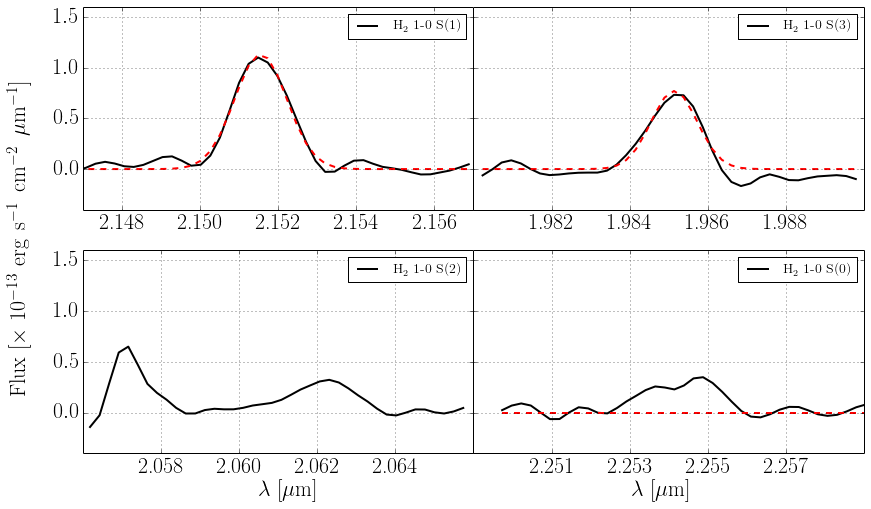

In [54]:
spec_WW=np.copy(spec_W)

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.002]    

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.02]    

#S1 line
#fit in wavelength:
coeff_S, var_matrix = curve_fit(gauss, wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1], p0=p0)
coeff_S=np.abs(coeff_S)

a_S=coeff_S[0]*(np.sqrt(2*np.pi)*coeff_S[2])
gauss_fit_Sw = gauss(wave[z_low_s1:z_up_s1], *coeff_S)

noise_S=np.mean([np.std(spec_WW[z_up_s1+10:z_up_s1+40]),np.std(spec_WW[z_low_s1-40:z_low_s1-10])])
noise_S_area=noise_S*(np.sqrt(2*np.pi)*coeff_S[2])

ass_fwhm=coeff_S[2]


#S3 line
#fit in wavelength:
p0 = [1.,1.98, 0.02]    

coeff_3S, var_matrix = curve_fit(gauss, wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3], p0=p0)
coeff_3S=np.abs(coeff_3S)

a_3S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_3S[2])
gauss_fit_3Sw = gauss(wave[z_low_s3:z_up_s3], *coeff_3S)
noise_3S=np.mean([np.std(spec_SS[z_up_s3+10:z_up_s3+40])])
noise_3S_area=noise_3S*(np.sqrt(2*np.pi)*coeff_3S[2])


#S2 line
#fit in wavelength:
p0 = [1.,2.062, 0.02]    

#coeff_2S, var_matrix = curve_fit(gauss, wave[z_low_s2:z_up_s2], spec_SS[z_low_s2:z_up_s2], p0=p0)
#coeff_2S=np.abs(coeff_2S)

#a_2S=coeff_2N[0]*(np.sqrt(2*np.pi)*coeff_2S[2])
#gauss_fit_2Sw = gauss(wave[z_low_s2:z_up_s2], *coeff_2S)

noise_2S=np.mean([np.std(spec_WW[z_up_s2+10:z_up_s2+40]),np.std(spec_WW[z_low_s2-40:z_low_s2-10])])
noise_2S_area=noise_2S*(np.sqrt(2*np.pi)*ass_fwhm)


#S0 line
#fit in wavelength:
p0 = [1.,2.253, 0.04]    

coeff_0S, var_matrix = curve_fit(gauss, wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0], p0=p0)
coeff_0S=np.abs(coeff_0S)

a_0S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_0S[2])
gauss_fit_0Sw = gauss(wave[z_low_s0:z_up_s0], *coeff_3S)

noise_0S=np.mean([np.std(spec_S[z_up_s0+10:z_up_s0+40])])
noise_0S_area=noise_0S*(np.sqrt(2*np.pi)*ass_fwhm)

#2-1 lines:

noise_213S=np.mean([np.std(spec_WW[z_low_213:z_up_213])])
noise_213S_area=noise_213S*(np.sqrt(2*np.pi)*ass_fwhm)

noise_211S=np.mean([np.std(spec_WW[z_low_211:z_up_211])])
noise_211S_area=noise_211S*(np.sqrt(2*np.pi)*ass_fwhm)

#bracket gamma
noise_brS=np.mean([np.std(spec_WW[z_up_br+10:z_up_br+40]),noise_S])
noise_brS_area=noise_brS*(np.sqrt(2*np.pi)*ass_fwhm)

##PLOT
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':2,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)

fig,a = plt.subplots(2,2, sharex=False,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

plt.ylim((-0.4, 1.6))

a[0,0].plot(wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[0,0].plot(wave[z_low_s1:z_up_s1], gauss_fit_Sw[:],ls='--',c='red')
a[0,0].set_xlim((2.147,2.157))
a[0,0].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

a[0,0].legend()
a[0,0].grid()

a[0,1].plot(wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(3)')
a[0,1].plot(wave[z_low_s3:z_up_s3], gauss_fit_3Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[0,1].set_xlim((1.980,1.990))
a[0,1].xaxis.set_ticks((1.982,1.984,1.986,1.988))
a[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[0,1].legend()
a[0,1].grid()

a[1,0].plot(wave[z_low_s2:z_up_s2], spec_WW[z_low_s2:z_up_s2],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(2)')
#a[1,0].plot(wave[z_low_s2:z_up_s2], gauss_fit_2Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[1,0].set_xlim((2.056,2.066))
a[1,0].xaxis.set_ticks((2.058,2.060,2.062,2.064))
a[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,0].legend()
a[1,0].grid()

a[1,1].plot(wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(0)')
a[1,1].plot(wave[z_low_s0:z_up_s0], gauss_fit_0Sw[:],ls='--',c='red')

a[1,1].set_xlim((2.249,2.259))
a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,1].legend()
a[1,1].grid()

fig.subplots_adjust(wspace=0);

print 'H2 1-0 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_S[2])

vel1=(C*(coeff_S[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S[1]+coeff_S[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)

print 'H2 1-0 S(3)\n'
print 'Flux  [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_3S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_3S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_3S[2])

vel1=(C*(coeff_3S[1]*1e-6-s3_0)/s3_0)*1e-3
vel2=(C*((coeff_3S[1]+coeff_3S[2])*1e-6-s3_0)/s3_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


#Determine noise and detection limits for other lines assuming a width of 100 km/s ~6.5e-4 mu m

print 'H2 1-0 S(2)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_2S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_2S_area)

print 'H2 1-0 S(0)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_0S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_0S_area)

print 'H2 2-1 S(3)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_213S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_213S_area)

print 'H2 2-1 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_211S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_211S_area)

print 'Si [IV]'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_3S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_3S_area)
print 'Bracket Gamma'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_brS_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_brS_area)

fig.savefig(out_fig_W,bbox_inches='tight')


#set fluxes output:

flux_W=[a_3S,noise_2S_area*3.,a_S,noise_0S_area*3.,noise_211S_area*3]
err_flux_W=[noise_3S_area,noise_2S_area,noise_S_area,noise_0S_area,noise_211S_area]

** East Region **

H2 1-0 S(1)

Flux [10^-13 erg s^-1 cm^-2]:
1.61e-03
Error [10^-13 erg s^-1 cm^-2]:
8.35e-05
Sigma Velocity [mu m]:
8.01e-04
Sigma Velocity [km s^-1]:
1.13e+02

H2 1-0 S(3)

Flux  [10^-13 erg s^-1 cm^-2]:
1.41e-03
Error [10^-13 erg s^-1 cm^-2]:
9.30e-05
Sigma Velocity [mu m]:
7.99e-04
Sigma Velocity [km s^-1]:
1.22e+02

H2 1-0 S(2)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.90e-04
Error [10^-13 erg s^-1 cm^-2]:
1.30e-04

H2 1-0 S(0)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.88e-04
Error [10^-13 erg s^-1 cm^-2]:
1.29e-04

H2 2-1 S(3)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
3.14e-04
Error [10^-13 erg s^-1 cm^-2]:
1.05e-04

H2 2-1 S(1)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
4.84e-04
Error [10^-13 erg s^-1 cm^-2]:
1.61e-04

Si [IV]
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
2.79e-04
Error [10^-13 erg s^-1 cm^-2]:
9.30e-05

Bracket Gamma
Flux  [10^-13 erg s^-1 cm^-2]:  upper limit
3.30e-04
Error [10^-13 erg s^-1 cm^-2]:
1.10e-04



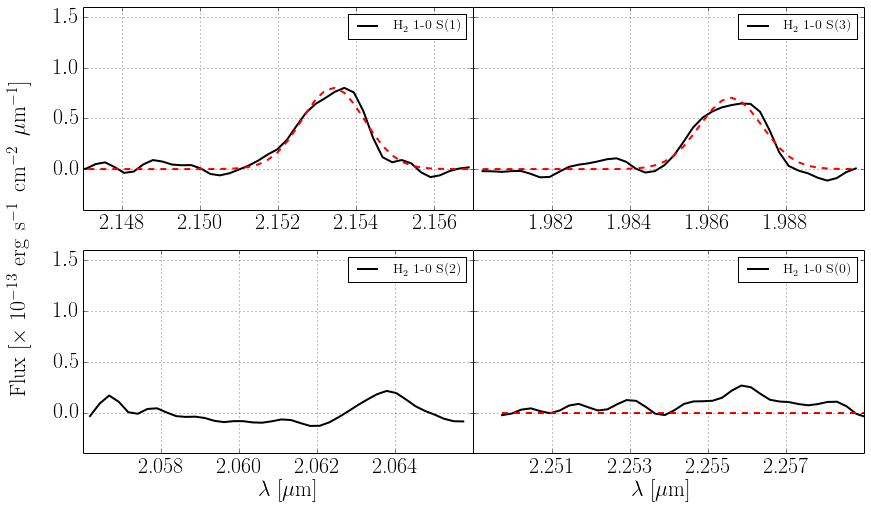

In [55]:
spec_WW=np.copy(spec_E)

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.002]    

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.02]    

#S1 line
#fit in wavelength:
coeff_S, var_matrix = curve_fit(gauss, wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1], p0=p0)
coeff_S=np.abs(coeff_S)

a_S=coeff_S[0]*(np.sqrt(2*np.pi)*coeff_S[2])
gauss_fit_Sw = gauss(wave[z_low_s1:z_up_s1], *coeff_S)

noise_S=np.mean([np.std(spec_WW[z_up_s1+10:z_up_s1+40]),np.std(spec_WW[z_low_s1-40:z_low_s1-10])])
noise_S_area=noise_S*(np.sqrt(2*np.pi)*coeff_S[2])


#S3 line
#fit in wavelength:
p0 = [1.,1.98, 0.02]    

coeff_3S, var_matrix = curve_fit(gauss, wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3], p0=p0)
coeff_3S=np.abs(coeff_3S)

a_3S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_3S[2])
gauss_fit_3Sw = gauss(wave[z_low_s3:z_up_s3], *coeff_3S)
noise_3S=np.mean([np.std(spec_SS[z_up_s3+10:z_up_s3+40])])
noise_3S_area=noise_3S*(np.sqrt(2*np.pi)*coeff_3S[2])

ass_fwhm=coeff_S[2]


#S2 line
#fit in wavelength:
p0 = [1.,2.062, 0.02]    

#coeff_2S, var_matrix = curve_fit(gauss, wave[z_low_s2:z_up_s2], spec_SS[z_low_s2:z_up_s2], p0=p0)
#coeff_2S=np.abs(coeff_2S)

#a_2S=coeff_2N[0]*(np.sqrt(2*np.pi)*coeff_2S[2])
#gauss_fit_2Sw = gauss(wave[z_low_s2:z_up_s2], *coeff_2S)

noise_2S=np.mean([np.std(spec_WW[z_up_s2+10:z_up_s2+40]),np.std(spec_WW[z_low_s2-40:z_low_s2-10])])
noise_2S_area=noise_2S*(np.sqrt(2*np.pi)*ass_fwhm)


#S0 line
#fit in wavelength:
p0 = [1.,2.253, 0.04]    

coeff_0S, var_matrix = curve_fit(gauss, wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0], p0=p0)
coeff_0S=np.abs(coeff_0S)

a_0S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_0S[2])
gauss_fit_0Sw = gauss(wave[z_low_s0:z_up_s0], *coeff_3S)

noise_0S=np.mean([np.std(spec_S[z_up_s0+10:z_up_s0+40])])
noise_0S_area=noise_0N*(np.sqrt(2*np.pi)*ass_fwhm)

#2-1 lines:

noise_213S=np.mean([np.std(spec_WW[z_low_213:z_up_213])])
noise_213S_area=noise_213S*(np.sqrt(2*np.pi)*ass_fwhm)

noise_211S=np.mean([np.std(spec_WW[z_low_211:z_up_211])])
noise_211S_area=noise_211S*(np.sqrt(2*np.pi)*ass_fwhm)

#bracket gamma
noise_brS=np.mean([np.std(spec_WW[z_up_br+10:z_up_br+40]),noise_S])
noise_brS_area=noise_brS*(np.sqrt(2*np.pi)*ass_fwhm)

##PLOT
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':2,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)

fig,a = plt.subplots(2,2, sharex=False,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

plt.ylim((-0.4, 1.6))

a[0,0].plot(wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[0,0].plot(wave[z_low_s1:z_up_s1], gauss_fit_Sw[:],ls='--',c='red')
a[0,0].set_xlim((2.147,2.157))
a[0,0].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

a[0,0].legend()
a[0,0].grid()

a[0,1].plot(wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(3)')
a[0,1].plot(wave[z_low_s3:z_up_s3], gauss_fit_3Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[0,1].set_xlim((1.980,1.990))
a[0,1].xaxis.set_ticks((1.982,1.984,1.986,1.988))
a[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[0,1].legend()
a[0,1].grid()

a[1,0].plot(wave[z_low_s2:z_up_s2], spec_WW[z_low_s2:z_up_s2],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(2)')
#a[1,0].plot(wave[z_low_s2:z_up_s2], gauss_fit_2Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[1,0].set_xlim((2.056,2.066))
a[1,0].xaxis.set_ticks((2.058,2.060,2.062,2.064))
a[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,0].legend()
a[1,0].grid()

a[1,1].plot(wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(0)')
a[1,1].plot(wave[z_low_s0:z_up_s0], gauss_fit_0Sw[:],ls='--',c='red')

a[1,1].set_xlim((2.249,2.259))
a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,1].legend()
a[1,1].grid()

fig.subplots_adjust(wspace=0);

print 'H2 1-0 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_S[2])

vel1=(C*(coeff_S[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S[1]+coeff_S[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)

print 'H2 1-0 S(3)\n'
print 'Flux  [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_3S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_3S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_3S[2])

vel1=(C*(coeff_3S[1]*1e-6-s3_0)/s3_0)*1e-3
vel2=(C*((coeff_3S[1]+coeff_3S[2])*1e-6-s3_0)/s3_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


#Determine noise and detection limits for other lines assuming a width of 100 km/s ~6.5e-4 mu m

print 'H2 1-0 S(2)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_2S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_2S_area)

print 'H2 1-0 S(0)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_0S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_0S_area)

print 'H2 2-1 S(3)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_213S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_213S_area)

print 'H2 2-1 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_211S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_211S_area)

print 'Si [IV]'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_3S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_3S_area)
print 'Bracket Gamma'
print 'Flux  [10^-13 erg s^-1 cm^-2]:  upper limit'
print '{0:.2e}'.format(noise_brS_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_brS_area)

fig.savefig(out_fig_E,bbox_inches='tight')


#set fluxes output:

flux_E=[a_3S,noise_2S_area*3.,a_S,noise_0S_area*3.,noise_211S_area*3]
err_flux_E=[noise_3S_area,noise_2S_area,noise_S_area,noise_0S_area,noise_211S_area]

** Central Region **

H2 1-0 S(1)

Flux [10^-13 erg s^-1 cm^-2]:
4.46e-03
Error [10^-13 erg s^-1 cm^-2]:
6.15e-04
Sigma Velocity [mu m]:
1.88e-03
Sigma Velocity [km s^-1]:
2.66e+02

H2 1-0 S(1) double gaussian

Flux [10^-13 erg s^-1 cm^-2]:
4.26e-03
Error [10^-13 erg s^-1 cm^-2]:
6.15e-04
Sigma Velocity [mu m]:
4.87e-04
1.49e-03
Sigma Velocity [km s^-1]:
6.88e+01
2.11e+02

H2 1-0 S(3)

Flux  [10^-13 erg s^-1 cm^-2]:
8.65e-04
Error [10^-13 erg s^-1 cm^-2]:
6.65e-05
Sigma Velocity [mu m]:
5.71e-04
Sigma Velocity [km s^-1]:
8.74e+01

H2 1-0 S(2)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
5.50e-04
Error [10^-13 erg s^-1 cm^-2]:
1.83e-04

H2 1-0 S(0)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
2.29e-04
Error [10^-13 erg s^-1 cm^-2]:
7.63e-05

H2 2-1 S(3)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
4.28e-04
Error [10^-13 erg s^-1 cm^-2]:
1.43e-04

H2 2-1 S(1)

Flux [10^-13 erg s^-1 cm^-2]: upper limit
5.53e-04
Error [10^-13 erg s^-1 cm^-2]:
1.84e-04

Si [IV]
Flux  [10^-13 erg s^-1 cm^-2]: upper limit
1.99e-04
Error

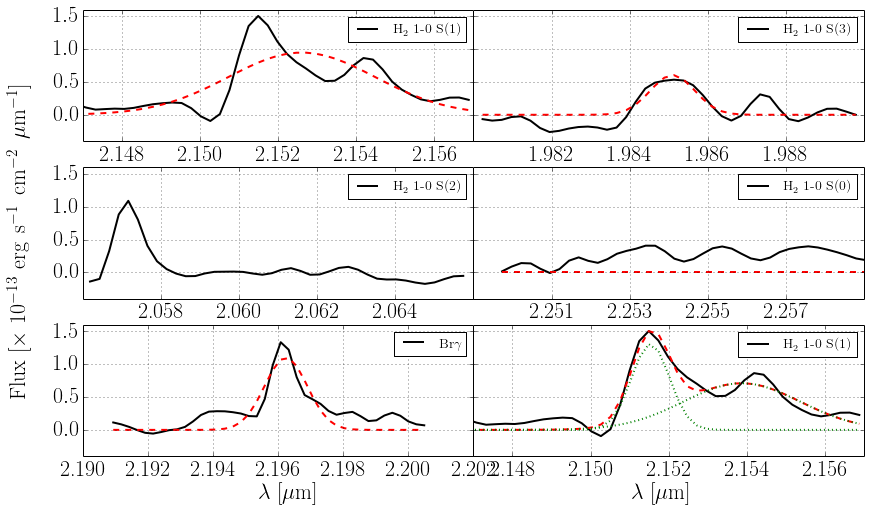

In [56]:
# Define model function to be used to fit to the data above:
def twogauss(x, *p):
    A1, mu1, sigma1,A2,mu2,sigma2 = p
    doublegauss=A1*numpy.exp(-(x-mu1)**2/(2.*sigma1**2))+A2*numpy.exp(-(x-mu2)**2/(2.*sigma2**2))
    return doublegauss

spec_WW=np.copy(spec_C)

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1.,2.15, 0.02]    

#S1 line
#fit in wavelength:
coeff_S, var_matrix = curve_fit(gauss, wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1], p0=p0)
coeff_S=np.abs(coeff_S)

a_S=coeff_S[0]*(np.sqrt(2*np.pi)*coeff_S[2])
gauss_fit_Sw = gauss(wave[z_low_s1:z_up_s1], *coeff_S)



noise_S=np.mean([np.std(spec_WW[z_low_s1-100:z_low_s1-30])])
noise_S_area=noise_S*(np.sqrt(2*np.pi)*coeff_S[2])

#2 gauss fit
p0 = [1.,2.15, 0.002,1.,2.156, 0.0006]    


coeff_S_d, var_matrix_d = curve_fit(twogauss, wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1], p0=p0)
coeff_S_d=np.abs(coeff_S_d)

coeff1=np.copy(coeff_S_d[0:3])
coeff2=np.copy(coeff_S_d[3:6])


a_S_d=coeff_S_d[0]*(np.sqrt(2*np.pi)*coeff_S_d[2])+coeff_S_d[3]*(np.sqrt(2*np.pi)*coeff_S_d[5])
gauss_dfit_Sw = twogauss(wave[z_low_s1:z_up_s1], *coeff_S_d)
gauss_dfit_Sw1 = gauss(wave[z_low_s1:z_up_s1], *coeff1)
gauss_dfit_Sw2 = gauss(wave[z_low_s1:z_up_s1], *coeff2)

#S3 line
#fit in wavelength:
p0 = [1.,1.98, 0.02]    

coeff_3S, var_matrix = curve_fit(gauss, wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3], p0=p0)
coeff_3S=np.abs(coeff_3S)

a_3S=coeff_3S[0]*(np.sqrt(2*np.pi)*coeff_3S[2])
gauss_fit_3Sw = gauss(wave[z_low_s3:z_up_s3], *coeff_3S)
noise_3S=np.mean([np.std(spec_SS[z_up_s3+10:z_up_s3+40])])
noise_3S_area=noise_3S*(np.sqrt(2*np.pi)*coeff_3S[2])

ass_fwhm=coeff_3S[2]


#S2 line
#fit in wavelength:
p0 = [1.,2.062, 0.02]    

#coeff_2S, var_matrix = curve_fit(gauss, wave[z_low_s2:z_up_s2], spec_SS[z_low_s2:z_up_s2], p0=p0)
#coeff_2S=np.abs(coeff_2S)

#a_2S=coeff_2N[0]*(np.sqrt(2*np.pi)*coeff_2S[2])
#gauss_fit_2Sw = gauss(wave[z_low_s2:z_up_s2], *coeff_2S)

noise_2S=np.mean([np.std(spec_WW[z_up_s2+10:z_up_s2+40]),np.std(spec_WW[z_low_s2-40:z_low_s2-10])])
noise_2S_area=noise_2S*(np.sqrt(2*np.pi)*ass_fwhm)


#S0 line
#fit in wavelength:
p0 = [1.,2.253, 0.04]    

coeff_0S, var_matrix = curve_fit(gauss, wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0], p0=p0)
coeff_0S=np.abs(coeff_0S)

a_0S=coeff_0S[0]*(np.sqrt(2*np.pi)*coeff_0S[2])
gauss_fit_0Sw = gauss(wave[z_low_s0:z_up_s0], *coeff_3S)

noise_0S=np.mean([np.std(spec_S[z_up_s0+10:z_up_s0+40])])
noise_0S_area=noise_0S*(np.sqrt(2*np.pi)*ass_fwhm)

#2-1 lines:

noise_213S=np.mean([np.std(spec_WW[z_low_213:z_up_213])])
noise_213S_area=noise_213S*(np.sqrt(2*np.pi)*ass_fwhm)

noise_211S=np.mean([np.std(spec_WW[z_low_211:z_up_211])])
noise_211S_area=noise_211S*(np.sqrt(2*np.pi)*ass_fwhm)

#Br gamma:
p0 = [1.,2.2, 0.04]    

coeff_brS, var_matrix = curve_fit(gauss, wave[z_low_br:z_up_br], spec_WW[z_low_br:z_up_br], p0=p0)
coeff_brS=np.abs(coeff_brS)

a_brS=coeff_brS[0]*(np.sqrt(2*np.pi)*coeff_brS[2])
gauss_fit_brSw = gauss(wave[z_low_br:z_up_br], *coeff_brS)

noise_brS=np.mean([np.std(spec_WW[z_up_br+10:z_up_br+40]),noise_S])
noise_brS_area=noise_brS*(np.sqrt(2*np.pi)*ass_fwhm)


##PLOT
params = {'legend.fontsize': 14,
           'axes.linewidth':1,
           'lines.linewidth':2,
           'legend.linewidth': 4,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
rc('font',**{'family':'serif','serif':['serif']})
plt.rcParams.update(params)

fig,a = plt.subplots(3,2, sharex=False,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Flux\,\,[$\times$ 10$^{-13}$\,\,erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)

plt.ylim((-0.4, 1.6))

a[0,0].plot(wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[0,0].plot(wave[z_low_s1:z_up_s1], gauss_fit_Sw[:],ls='--',c='red')
a[0,0].set_xlim((2.147,2.157))
a[0,0].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

a[0,0].legend()
a[0,0].grid()

a[0,1].plot(wave[z_low_s3:z_up_s3], spec_WW[z_low_s3:z_up_s3],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(3)')
a[0,1].plot(wave[z_low_s3:z_up_s3], gauss_fit_3Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[0,1].set_xlim((1.980,1.990))
a[0,1].xaxis.set_ticks((1.982,1.984,1.986,1.988))
a[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[0,1].legend()
a[0,1].grid()

a[1,0].plot(wave[z_low_s2:z_up_s2], spec_WW[z_low_s2:z_up_s2],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(2)')
#a[1,0].plot(wave[z_low_s2:z_up_s2], gauss_fit_2Sw[:],ls='--',c='red')
#plt.ylabel(r'Flux\,\,[$\times\, 10^{-13}$\,\, erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]',fontsize=22)
#plt.xlabel(r'$\lambda$ [$\mu$m]',fontsize=22)

a[1,0].set_xlim((2.056,2.066))
a[1,0].xaxis.set_ticks((2.058,2.060,2.062,2.064))
a[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,0].legend()
a[1,0].grid()

a[1,1].plot(wave[z_low_s0:z_up_s0], spec_WW[z_low_s0:z_up_s0],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(0)')
a[1,1].plot(wave[z_low_s0:z_up_s0], gauss_fit_0Sw[:],ls='--',c='red')

a[1,1].set_xlim((2.249,2.259))
a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[1,1].legend()
a[1,1].grid()

a[2,0].plot(wave[z_low_br:z_up_br], spec_WW[z_low_br:z_up_br],ls='-',c='black',label=r'Br$\gamma$')
a[2,0].plot(wave[z_low_br:z_up_br], gauss_fit_brSw[:],ls='--',c='red')

#a[1,1].set_xlim((2.249,2.259))
#a[1,1].xaxis.set_ticks((2.251,2.253,2.255,2.257))
a[2,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[2,0].legend()
a[2,0].grid()

a[2,1].plot(wave[z_low_s1:z_up_s1], spec_WW[z_low_s1:z_up_s1],ls='-',c='black',label=r'H$_2$\,\,1-0\,\,S(1)')
a[2,1].plot(wave[z_low_s1:z_up_s1], gauss_dfit_Sw[:],ls='--',c='red')
a[2,1].plot(wave[z_low_s1:z_up_s1], gauss_dfit_Sw1[:],ls=':',c='green')
a[2,1].plot(wave[z_low_s1:z_up_s1], gauss_dfit_Sw2[:],ls=':',c='green')

a[2,1].set_xlim((2.147,2.157))
a[2,1].xaxis.set_ticks((2.148,2.150,2.152,2.154,2.156))
a[2,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
a[2,1].legend()
a[2,1].grid()


fig.subplots_adjust(wspace=0);

print 'H2 1-0 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_S[2])

vel1=(C*(coeff_S[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S[1]+coeff_S[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


print 'H2 1-0 S(1) double gaussian\n'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_S_d)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_S_d[2])
print '{0:.2e}'.format(coeff_S_d[5])


vel1=(C*(coeff_S_d[1]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S_d[1]+coeff_S_d[2])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}'.format(velsig)

vel1=(C*(coeff_S_d[4]*1e-6-s1_0)/s1_0)*1e-3
vel2=(C*((coeff_S_d[4]+coeff_S_d[5])*1e-6-s1_0)/s1_0)*1e-3
velsig=vel2-vel1
print '{0:.2e}\n'.format(velsig)

print 'H2 1-0 S(3)\n'
print 'Flux  [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_3S)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_3S_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_3S[2])

vel1=(C*(coeff_3S[1]*1e-6-s3_0)/s3_0)*1e-3
vel2=(C*((coeff_3S[1]+coeff_3S[2])*1e-6-s3_0)/s3_0)*1e-3
velsig=vel2-vel1
print 'Sigma Velocity [km s^-1]:'
print '{0:.2e}\n'.format(velsig)


#Determine noise and detection limits for other lines assuming a width of 100 km/s ~6.5e-4 mu m




print 'H2 1-0 S(2)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_2S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_2S_area)



print 'H2 1-0 S(0)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_0S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_0S_area)

print 'H2 2-1 S(3)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_213S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_213S_area)

print 'H2 2-1 S(1)\n'
print 'Flux [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_211S_area*3)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_211S_area)

print 'Si [IV]'
print 'Flux  [10^-13 erg s^-1 cm^-2]: upper limit'
print '{0:.2e}'.format(noise_3S_area*3.)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}\n'.format(noise_3S_area)

print 'Br Gamma'
print 'Flux [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(a_brS)
print 'Error [10^-13 erg s^-1 cm^-2]:'
print '{0:.2e}'.format(noise_brS_area)
print 'Sigma Velocity [mu m]:'
print '{0:.2e}'.format(coeff_brS[2])

fig.savefig(out_fig_C,bbox_inches='tight')


#set fluxes output:

flux_C=[a_3S,noise_2S_area*3.,a_S,noise_0S_area*3.,noise_211S_area*3]
err_flux_C=[noise_3S_area,noise_2S_area,noise_S_area,noise_0S_area,noise_211S_area]

# Temperature diagnostics: #

The temperature is determined in the five regions from the flux of the lines or their upper limit:

$$ \ln({\rm F})=1/T * (T_{\rm lines} - T_{\rm line_{S1}}) $$

where $T_{\rm lines}$ are tabulated values. Fluxes are measured from the fit / detection limit.

Alternative estimate of the temperature (from the upper limit of the 2-1 S(1) line):

$$ T\propto\frac{\rm F(2-1\, S(1))}{F(1-0\, S(1))} $$

Temperature

North
1558.64355945
South
1136.37389244
West
1141.62604886
East
1647.36405787
Centre
597.539038431


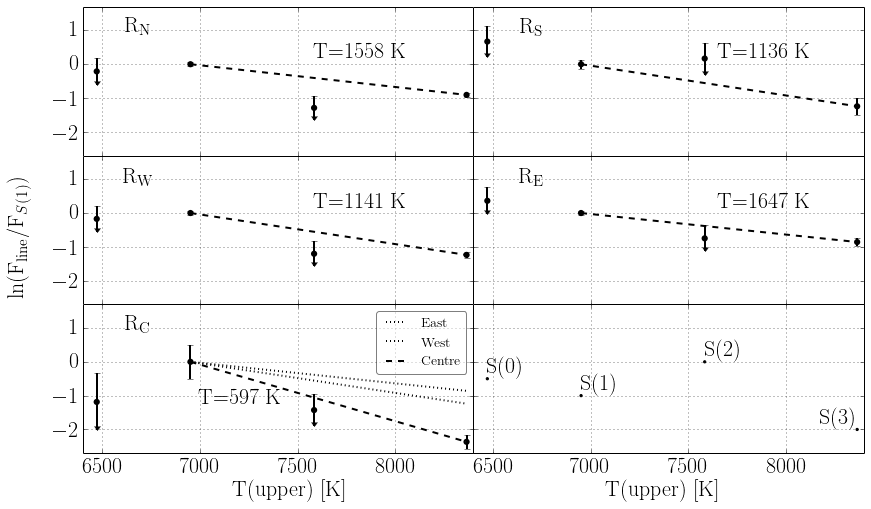

In [57]:
#TEMPERATURE

#define output file name

out_file_t=root_figures+'temperature_regions.pdf'

#set x axis : T_lines

T_L=[8364.93,7584.27,6951.28,6471.32 ]

g=[33.,9.,21.,5.] #statistical weigth of the transition

A=[4.20725E-7,3.98185E-7,3.47057E-7,2.52648E-7] #transition probability

freq=[1.5096810e+14,1.4531165E+14,1.3928029E+14,1.348412081E14] #frequency of the transition

line_str=['S(0)','S(1)','S(2)','S(3)']

#North
flux_corrN=[]
err_flux_corrN=[]
for i in xrange(0,len(T_L)):
    
    flux_corrN.append((flux_N[i]*freq[2]*g[2]*A[2])/(flux_N[2]*freq[i]*g[i]*A[i]))
    #err_flux_corr.append((err_flux_N[i]*err_flux_N[2]))

log_fluxN=np.log(flux_corrN)
#log_err_flux=np.log(err_flux_corr)
#turn it around for plotting with ascending T lines
log_fluxN=log_fluxN[::-1]

#South
flux_corrS=[]
err_flux_corrS=[]
for i in xrange(0,len(T_L)):
    
    flux_corrS.append((flux_S[i]*freq[2]*g[2]*A[2])/(flux_S[2]*freq[i]*g[i]*A[i]))
    #err_flux_corr.append((err_flux_C[i]*err_flux_C[2]))

log_fluxS=np.log(flux_corrS)
#log_err_flux=np.log(err_flux_corr)
#turn it around for plotting with ascending T lines
log_fluxS=log_fluxS[::-1]

#West
flux_corrW=[]
err_flux_corrW=[]
for i in xrange(0,len(T_L)):
    
    flux_corrW.append((flux_W[i]*freq[2]*g[2]*A[2])/(flux_W[2]*freq[i]*g[i]*A[i]))
    #err_flux_corr.append((err_flux_C[i]*err_flux_C[2]))

log_fluxW=np.log(flux_corrW)
#log_err_flux=np.log(err_flux_corr)
#turn it around for plotting with ascending T lines
log_fluxW=log_fluxW[::-1]

#East
flux_corrE=[]
err_flux_corrE=[]
for i in xrange(0,len(T_L)):
    
    flux_corrE.append((flux_E[i]*freq[2]*g[2]*A[2])/(flux_E[2]*freq[i]*g[i]*A[i]))
    #err_flux_corr.append((err_flux_C[i]*err_flux_C[2]))

log_fluxE=np.log(flux_corrE)
#log_err_flux=np.log(err_flux_corr)
#turn it around for plotting with ascending T lines
log_fluxE=log_fluxE[::-1]

#Centre
flux_corrC=[]
err_flux_corrC=[]
for i in xrange(0,len(T_L)):
    
    flux_corrC.append((flux_C[i]*freq[2]*g[2]*A[2])/(flux_C[2]*freq[i]*g[i]*A[i]))
    #err_flux_corr.append((err_flux_C[i]*err_flux_C[2]))

log_fluxC=np.log(flux_corrC)
#log_err_flux=np.log(err_flux_corr)
#turn it around for plotting with ascending T lines
log_fluxC=log_fluxC[::-1]


#estimate temperature:
#North
m=(log_fluxN[1]-log_fluxN[3])/(T_L[2]-T_L[0])
TN=-1./m
print 'Temperature\n'
print 'North'
print TN

#South
m=(log_fluxS[1]-log_fluxS[3])/(T_L[2]-T_L[0])
TS=-1./m
print 'South'
print TS

#West
m=(log_fluxW[1]-log_fluxW[3])/(T_L[2]-T_L[0])
TW=-1./m
print 'West'
print TW

#East
m=(log_fluxE[1]-log_fluxE[3])/(T_L[2]-T_L[0])
TE=-1./m
print 'East'
print TE

#Centre
m=(log_fluxC[1]-log_fluxC[3])/(T_L[2]-T_L[0])
TC=-1./m
print 'Centre'
print TC

#linfit:

x_line=[T_L[2],T_L[0]]
x_line_upp=[T_L[3],T_L[1]]

y_lineN=[log_fluxN[1],log_fluxN[3]]
y_lineS=[log_fluxS[1],log_fluxS[3]]
y_lineW=[log_fluxW[1],log_fluxW[3]]
y_lineE=[log_fluxE[1],log_fluxE[3]]
y_lineC=[log_fluxC[1],log_fluxC[3]]

#up limits

y_uppN=[log_fluxN[0],log_fluxN[2]]
y_uppS=[log_fluxS[0],log_fluxS[2]]
y_uppW=[log_fluxW[0],log_fluxW[2]]
y_uppE=[log_fluxE[0],log_fluxE[2]]
y_uppC=[log_fluxC[0],log_fluxC[2]]


#errors:

err_lineN=[2*err_flux_N[2]/flux_N[2],err_flux_N[2]/flux_N[2]+err_flux_N[0]/flux_N[0]]
err_lineS=[2*err_flux_S[2]/flux_N[2],err_flux_S[2]/flux_S[2]+err_flux_S[0]/flux_S[0]]
err_lineW=[2*err_flux_W[2]/flux_N[2],err_flux_W[2]/flux_W[2]+err_flux_W[0]/flux_W[0]]
err_lineE=[2*err_flux_E[2]/flux_N[2],err_flux_E[2]/flux_E[2]+err_flux_E[0]/flux_E[0]]
err_lineC=[2*err_flux_C[2]/flux_N[2],err_flux_C[2]/flux_C[2]+err_flux_C[0]/flux_C[0]]

#errors upper limits:
err_lineNu=[2*err_flux_N[2]/flux_N[2]+err_flux_N[3]/flux_N[3],err_flux_N[2]/flux_N[2]+err_flux_N[1]/flux_N[1]]
err_lineSu=[2*err_flux_S[2]/flux_N[2]+err_flux_N[3]/flux_N[3],err_flux_S[2]/flux_S[2]+err_flux_S[1]/flux_S[1]]
err_lineWu=[2*err_flux_W[2]/flux_N[2]+err_flux_N[3]/flux_N[3],err_flux_W[2]/flux_W[2]+err_flux_W[1]/flux_W[1]]
err_lineEu=[2*err_flux_E[2]/flux_N[2]+err_flux_N[3]/flux_N[3],err_flux_E[2]/flux_E[2]+err_flux_E[1]/flux_E[1]]
err_lineCu=[2*err_flux_C[2]/flux_N[2]+err_flux_N[3]/flux_N[3],err_flux_C[2]/flux_C[2]+err_flux_C[1]/flux_C[1]]


#PLOT
fig,a = plt.subplots(3,2, sharex=True,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'ln(F$_{\rm line}$/F$_{S(1)}$)', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.33, 0.05, r'T(upper) [K]', ha='center',fontsize=22)
fig.text(0.7, 0.05, r'T(upper) [K]', ha='center',fontsize=22)
#annotate regions
fig.text(0.18, 0.85, r'R$_{\rm N}$', ha='center',fontsize=22)
fig.text(0.18, 0.59, r'R$_{\rm W}$', ha='center',fontsize=22)
fig.text(0.18, 0.335, r'R$_{\rm C}$', ha='center',fontsize=22)
fig.text(0.57, 0.85, r'R$_{\rm S}$', ha='center',fontsize=22)
fig.text(0.57, 0.59, r'R$_{\rm E}$', ha='center',fontsize=22)


#annotate temperatures:
#annotate regions
fig.text(0.4, 0.81, r'T='+str(int(TN))+' K', ha='center',fontsize=22)
fig.text(0.4, 0.55, r'T='+str(int(TW))+' K', ha='center',fontsize=22)
fig.text(0.28, 0.21, r'T='+str(int(TC))+' K', ha='center',fontsize=22)
fig.text(0.8, 0.81, r'T='+str(int(TS))+' K', ha='center',fontsize=22)
fig.text(0.8, 0.55, r'T='+str(int(TE))+' K', ha='center',fontsize=22)
plt.xlim((6400,8400))
plt.ylim((-2.7,1.7))

a[0,0].yaxis.set_ticks((-2.0,-1.0,0.0,1.0))
a[0,0].xaxis.set_ticks((6500,7000,7500,8000))


a[0,0].scatter(T_L[::-1], log_fluxN[:],marker='.',c='black',lw=4)
a[0,0].plot(x_line,y_lineN,c='black',ls='--')
a[0,0].errorbar(x_line, y_lineN, yerr=err_lineN, fmt=' ',c='black')
a[0,0].errorbar(x_line_upp, y_uppN, yerr=err_lineNu, lolims=True, ls=' ',c='black')
a[0,0].grid()

a[0,1].scatter(T_L[::-1], log_fluxS[:],marker='.',c='black',lw=4)
a[0,1].plot(x_line,y_lineS,c='black',ls='--')
a[0,1].errorbar(x_line, y_lineS, yerr=err_lineS, fmt=' ',c='black')
a[0,1].errorbar(x_line_upp, y_uppS, yerr=err_lineSu, lolims=True, ls=' ',c='black')
a[0,1].grid()



a[1,0].scatter(T_L[::-1], log_fluxW[:],marker='.',c='black',lw=4)
a[1,0].plot(x_line,y_lineW,c='black',ls='--')
a[1,0].errorbar(x_line, y_lineW, yerr=err_lineW, fmt=' ',c='black')
a[1,0].errorbar(x_line_upp, y_uppW, yerr=err_lineWu, lolims=True, ls=' ',c='black')
a[1,0].grid()



a[1,1].scatter(T_L[::-1], log_fluxE[:],marker='.',c='black',lw=4)
a[1,1].plot(x_line,y_lineE,c='black',ls='--')
a[1,1].errorbar(x_line, y_lineE, yerr=err_lineE, fmt=' ',c='black')
a[1,1].errorbar(x_line_upp, y_uppE, yerr=err_lineEu, lolims=True, ls=' ',c='black')
a[1,1].grid()


a[2,0].scatter(T_L[::-1], log_fluxC[:],marker='.',c='black',lw=4)
a[2,0].errorbar(x_line, y_lineC, yerr=err_lineC, fmt=' ',c='black')
a[2,0].errorbar(x_line_upp, y_uppC, yerr=err_lineCu, lolims=True, ls=' ',c='black')


a[2,0].grid()
a[2,0].plot(x_line,y_lineE,c='black',ls=':',label='East')

a[2,0].plot(x_line,y_lineW,c='black',ls=':',label='West')
a[2,0].plot(x_line,y_lineC,c='black',ls='--',label='Centre')

leg= a[2,0].legend(fancybox=True)

leg.get_frame().set_alpha(0.5)
fig.subplots_adjust(wspace=0);
fig.subplots_adjust(hspace=0);

log_flux_ex=[-0.5,-1.0,0.0,-2]
a[2,1].scatter(T_L[::-1], log_flux_ex[:],marker='.',c='black',lw=1)
T_L_inv=T_L[::-1]

for i in xrange(0,len(T_L)):
    if i!=3:
        hal='left'
    else:
        hal='right'
    a[2,1].annotate(line_str[i], (T_L_inv[i],log_flux_ex[i]),ha=hal,va='bottom',fontsize=22)
a[2,1].grid()

fig.savefig(out_file_t,bbox_inches='tight')



**************
# Fluxes, Luminosities, Masses and Accretion Rates

Extract the flux of the line from a selected region, compute the luminosity and the mass of the gas


Flux : it automatically converts the cubes in $\rm W/cm^2$ into $\rm erg\,s^{-1}\,cm^{-2}$

Luminosity:

$$ L\,= \,4\pi\,D_L^2\, F_{\rm H_2 1-0 S(1)} $$

Mass of the warm gas (Storchi-Bergmann et al. 2009):

$$ M_{\rm H2}^{\rm warm} =  5.0776\times10^{13}\bigg(\frac{F_{\rm H_2 1-0 S(1)}}{\rm erg s^{-1} cm^{-2}}\bigg) \bigg(\frac{D}{\rm Mpc}\bigg)^2 $$

Masses of the cold gas (1,2 - Muller-Sanchez et al. 2006; 3 - Mazzalay et al. 2013):

$$ M_{\rm H2}^{\rm cold} = 4000 \frac{M_\odot}{L_\odot}$$


$$ M_{\rm H2}^{\rm cold} = 1-5 \times 10^6\,\, M_{\rm H2}^{\rm warm} $$


$$ M_{\rm H2}^{\rm cold} = 1174 \frac{M_\odot}{L_\odot}$$

Accretion rate:

- timescale of the accretion given by the velocity of the clouds v and the distance from the nucleus

$$ t_{\rm accretion} = \frac{d}{v} = \frac{75\,{\rm pc}}{100\,{\rm
km\,s^{-1}}}\,\,\,[{\rm years}] $$

- accretion rate:

$$\dot{M}= \frac{M_{\rm gas}}{t_{\rm accretion}}\,\,\,[{\rm M_\odot\, yr^{-1}}] $$

**********

Define the main parameters:

    - Input file: final non hanned cube
    - Output file: text file
    
    - Location of the line
    - Regions of the field of view
        - Centre: C
        - Inner Disk: IN
    - Flux cutoff
    - Normalization factors for readable units
        
    - Constants:
        - luminosity distance
        - dust exctinction for the mass (set to zero,usually)
        
    - Accretion rates:
        - Infall velocity of the cloud
        - Distance of the cloud
        - Mass HI clouds in Solar Masses

In [ ]:
#filenames

in_file=root_cube+'nh.fits' 
out_txt=rootdir+'analysis_results.txt'
out_fig=root_figures+'spectrum_inner_disk.pdf'
#region of the field of view

#CENTRE
x_lC=37
x_rC=43
y_dC=37
y_uC=42
#deviating component in the centre in channels
z_lowC=922
z_upC=926

#INNER DISK
x_lIN=19
x_rIN=60
y_dIN=27
y_uIN=50
#location of the line in channels
z_lowIN=900
z_upIN=930


#cutoff

#normalization factors for readable units
norm_flux=1e-13
norm_flux_str=' x 10^-13 '
norm_mass=1e8
norm_mass_str=' x 10^8 '
norm_time=1e5
norm_time_str=' x 10^5 '
norm_accr=1e-2
norm_accr_str=' x 10^-2 '


#Constants
D_L=62.4 #Mpc
LSun= 3.846e33

#Accretion
vel_cloud= 100. #km/s
d_pc = 75. #pc
mHI=1e4



Main of the ANALYSIS

In [ ]:
#MAIN
f=pyfits.open(in_file)
infile=f[0].data
head=f[0].header

xlen = infile.shape[2]
ylen = infile.shape[1]
zlen = infile.shape[0]

infilecool=np.zeros([zlen,ylen,xlen])

value=1.2e-20
infilespecdev=np.zeros([zlen])
for j in xrange(y_dC,y_uC):
    for i in xrange(x_lC,x_rC):
        infilespecdev[:]+=infile[:,j,i] 
        for k in xrange(z_lowC,z_upC):

            if infile[k,j,i]>=value:
                infilecool[k,j,i]=infile[k,j,i]


flux_dev= np.sum(infilecool[:,:,:])


value=1.5e-20
infilecool=np.zeros([zlen,ylen,xlen])
infilespec=np.zeros([zlen])

for j in xrange(y_dIN,y_uIN):
    for i in xrange(x_lIN,x_rIN):
        infilespec[:]+=infile[:,j,i] 
        for k in xrange(z_lowIN,z_upIN):

            if infile[k,j,i]>=value:
                infilecool[k,j,i]=infile[k,j,i]

                
flux_disk=np.sum(infilecool[:,:,:])


#set the right units
flux_disk=np.multiply(flux_disk,(wave[z_upIN-6]-wave[z_lowIN+5]))
flux_dev=np.multiply(flux_dev,(wave[z_upC]-wave[z_lowC]))

#### CONVERT TO THE RIGHT UNITS
#from W cm^-2 to erg s^-1 cm^-2: x 1e7 

infilespec=infilespec*1e7
infilespecdev=infilespecdev*1e7

p0 = [1.,2.151, 0.04]    

coeff_IN, var_matrix = curve_fit(gauss, wave[z_lowIN:z_upIN], infilespec[z_lowIN:z_upIN], p0=p0)
coeff_IN=np.abs(coeff_IN)

a_IN=coeff_IN[0]*(np.sqrt(2*np.pi)*coeff_IN[2])
gauss_fit_IN = gauss(wave[z_lowIN-20:z_upIN+20], *coeff_IN)

p0 = [1.,2.154, 0.0004]    

coeff_DEV, var_matrix = curve_fit(gauss, wave[z_lowC:z_upC], infilespec[z_lowC:z_upC], p0=p0)
coeff_DEV=np.abs(coeff_DEV)

a_DEV=coeff_DEV[0]*(np.sqrt(2*np.pi)*coeff_DEV[2])
gauss_fit_DEV = gauss(wave[z_lowC-20:z_upC+20], *coeff_DEV)





#flux_disk_erg=flux_disk*1e7
#flux_dev_erg=flux_dev*1e7

flux_disk_erg=a_IN
flux_dev_erg=a_DEV/4.  #add factor 4 because the gaussian over estimates the flux
flux_disk_p=round(flux_disk_erg/norm_flux,5)


flux_dev_p=round(flux_dev_erg/norm_flux,5)


print 'Flux INNER DISK'
print str(flux_disk_p)+norm_flux_str+'erg s^-1 cm^-2 \n'
print 'Flux DEVIATING COMPONENT'
print str(flux_dev_p)+norm_flux_str+'erg s^-1 cm^-2 \n'

# FLUX -> LUMINOSITY

lum_disk=flux_disk_erg*4*math.pi*pow(D_L*1e6*3.0857e18 ,2)
lum_dev=flux_dev_erg*4*math.pi*pow(D_L*1e6*3.0857e18 ,2)

print 'Luminosity INNER DISK'
print str(lum_disk)+' erg s^-1 \n'
print 'Luminosity DEVIATING COMPONENT'
print str(lum_dev)+' erg s^-1 \n'


#FLUX -> MASS
#define some constants
K=5.08e13

# the flux in the formula must be in erg/scm2
m_warm_dev=K* (D_L*D_L) * flux_dev_erg
m_warm_disk=K* (D_L*D_L) * flux_disk_erg

print '***** MASS WARM H2 ****'

print 'Mass INNER DISK'
print str(m_warm_disk)+' MSun \n'
print 'Mass DEVIATING COMPONENT'
print str(m_warm_dev)+' MSun \n'

#Luminosity -> MASS


mcold_diskMS=1174*lum_disk/LSun
mcold_devMS=1174*lum_dev/LSun

mcold_diskMSM=1e6*m_warm_disk
mcold_devMSM=1e6*m_warm_dev


mcold_diskM=4000*lum_disk/LSun
mcold_devM=4000*lum_dev/LSun


print '***** MASS COLD H2 ****'
print 'Muller-Sanchez'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskMS/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devMS/norm_mass)+norm_mass_str+' MSun \n'

print 'Muller-Sanchez warm mass'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskMSM/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devMSM/norm_mass)+norm_mass_str+' MSun \n'

print 'Mazzalay'
print 'Mass cold H2 INNER DISK'
print str(mcold_diskM/norm_mass)+norm_mass_str+' MSun \n'
print 'Mass cold H2 DEVIATING COMPONENT'
print str(mcold_devM/norm_mass)+norm_mass_str+' MSun \n'

## ACCRETION RATE
#timescale for the accretion

d_pc=d_pc*PC*1e-5 #d in km

timescale=d_pc/(vel_cloud*3600.*24.*365.) #timescale in years
print '***** ACCRETION RATES *****'
print str(timescale/norm_time)+norm_time_str+' years - timescale \n'

#accretion rate

#warm H2
mass=m_warm_dev

accretion=mass/timescale
print 'WARM H2'
print str(accretion)+' Msun/year - Accretion rate \n'

#warm H2
mass=mcold_devM

accretion=mass/timescale
print 'COLD H2'
print str(accretion)+' Msun/year - Accretion rate \n'

#warm H2
mass=mHI

accretion=mass/timescale
print 'HI'
print str(accretion)+' Msun/year - Accretion rate \n'


#plot average spectrum:
#PLOT
fig,a = plt.subplots(1,1, sharex=True,sharey=True,figsize=(14,8))
fig.text(0.05, 0.5, r'Integrated Flux\,\,[erg\, s$^{-1}$\, cm$^{-2}$\, $\mu$m$^{-1}$]', va='center',
         rotation='vertical',fontsize=22)
fig.text(0.5, 0.05, r'$\lambda$ [$\mu$m]', ha='center',fontsize=22)
fig.text(0.25, 0.8, r'H$_2$\,\,1-0\,\,S(1) Inner disk', ha='center',fontsize=22)


a.plot(wave[z_lowIN-20:z_upIN+20],infilespec[z_lowIN-20:z_upIN+20],c='black',label='Integrated spectrum')
a.plot(wave[z_lowIN-20:z_upIN+20],gauss_fit_IN[:],c='red',ls='--')
a.plot(wave[z_lowC-2:z_upC+1],infilespec[z_lowC-2:z_upC+1],c='green',ls='-.',lw=8,label='Deviating Component')

a.plot(wave[z_lowC-20:z_upC+20],gauss_fit_DEV[:],c='blue',ls='--',)
plt.legend()
plt.grid()
fig.savefig(out_fig,bbox_inches='tight')
